# Miscellaneous

* Importing Packages
* Defining data sources

Nothing really interesting happening here.  

In [7]:
import pandas 

In [8]:
pandas.__file__

'C:\\Users\\F10_Purchasing\\AppData\\Roaming\\Python\\Python37\\site-packages\\pandas\\__init__.py'

In [11]:
import os
import tqdm
import time
from math import ceil
import typing

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pylab as plt
import seaborn as sns
# visualising the missing data 
import missingno as msno
# import plotly.express as px

import pandas as pd
import numpy as np

from sklearn import tree
# from dtreeviz.trees import dtreeviz # will be used for tree visualization
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [12]:
def normalised(x):
    numerator = (x - x.min())
    denominator = (x.max() - x.min())
    if denominator == 0:
        return denominator + 1
    else:
        return numerator/denominator
    
def plotConfusionMatrix(yTrue, yPred, yPredProba):
    
    labels = np.unique(np.concatenate([yTrue, yPred], axis = None))
    data = confusion_matrix(yTrue, yPred)
    df_cm = pd.DataFrame(data, columns=labels, index = labels)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (15,5))
    
    plt.subplot(1,2,1)
    plt.title('Confusion Matrix')
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True)# font size
    
    plt.subplot(1,2,2)
    # plt.figure(figsize=(7,7))
    fpr, tpr, thresholds = roc_curve(yTrue, yPredProba)
    auc = roc_auc_score(yTrue, yPredProba)
    plt.plot(fpr, tpr, label=f'{auc:.2}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(title = 'AUC Score')
    
    print(classification_report(yTrue, yPred))
    print('===================================================')

In [13]:
path_data = os.path.join('.','data')
path_raw = os.path.join(path_data, 'raw_original')

In [14]:
csv_all = [(file_name, pd.read_csv(os.path.join(path_raw,file_name))) for file_name in os.listdir(path_raw)]
csv_all = dict(csv_all)

# look at the columns of each csv
for name, csv in csv_all.items():
    print(name,':')
    print(csv.columns.tolist())
    print('Number of Rows:', csv.shape[0])
    print('Number of ID:', len(csv['id'].unique()))
    print('\n===================')

T_creatinine.csv :
['id', 'value', 'time']
Number of Rows: 1439
Number of ID: 300

T_DBP.csv :
['id', 'value', 'time']
Number of Rows: 1821
Number of ID: 300

T_demo.csv :
['id', 'race', 'gender', 'age']
Number of Rows: 300
Number of ID: 300

T_glucose.csv :
['id', 'value', 'time']
Number of Rows: 1556
Number of ID: 300

T_HGB.csv :
['id', 'value', 'time']
Number of Rows: 2025
Number of ID: 300

T_ldl.csv :
['id', 'value', 'time']
Number of Rows: 1261
Number of ID: 300

T_meds.csv :
['id', 'drug', 'daily_dosage', 'start_day', 'end_day']
Number of Rows: 2181
Number of ID: 272

T_SBP.csv :
['id', 'value', 'time']
Number of Rows: 1809
Number of ID: 300

T_stage.csv :
['id', 'Stage_Progress']
Number of Rows: 300
Number of ID: 300



# Data Exploration  

## Merging Measure Data

Data that is related to measurement is merged into one single dataframe, such that each row is the measurement of a patient at a given time.  

In [15]:
measurements = ['creatinine', 'DBP', 'glucose', 'HGB', 'ldl', 'SBP']

In [16]:
df_patients = pd.merge(csv_all['T_demo.csv'], csv_all['T_stage.csv'],
                       on = 'id', how = 'inner')
# df_patients.to_csv(os.path.join(path_data, 'Patients.csv'), index = False)

In [17]:
left_df = pd.DataFrame({'id':[], 'time':[]})

for file_name, csv in csv_all.items():
    if 'value' not in csv.columns:
        # not one of the measurement csv
        continue 
    else:
        measurement = file_name[2:-4]
        left_df = pd.merge(left_df, csv,
                           on = ['id', 'time'], how = 'outer')
        left_df = left_df.rename(columns = {'value': measurement})

In [18]:
df_patientMeasure = pd.merge(df_patients, left_df,
                            on = 'id', how = 'inner')
df_patientMeasure = df_patientMeasure.sort_values(['id', 'time'])
df_patientMeasure.head()

,id,race,gender,age,Stage_Progress,creatinine,time,DBP,glucose,HGB,ldl,SBP
0,0,Unknown,Male,70,True,1.29,0,95.32,6.24,13.51,161.49,134.11
6,0,Unknown,Male,70,True,NaN,98,83.98,NaN,NaN,NaN,133.75
1,0,Unknown,Male,70,True,1.15,107,NaN,7.20,13.39,111.39,NaN
7,0,Unknown,Male,70,True,NaN,279,65.97,NaN,NaN,NaN,125.08
2,0,Unknown,Male,70,True,1.44,286,NaN,7.01,12.84,NaN,NaN


In [19]:
df_patientMeasure.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4761.0,148.060912,88.343602,0.00,70.00,147.00,227.00,299.00
age,4761.0,70.889519,9.057518,46.00,65.00,72.00,78.00,86.00
creatinine,1439.0,1.328999,0.357971,0.24,1.08,1.29,1.53,3.02
time,4761.0,462.419240,334.499640,0.00,196.00,414.00,640.00,1429.00
DBP,1821.0,79.518583,10.178676,44.95,72.83,79.05,86.17,112.93
glucose,1556.0,6.694833,1.599058,2.89,5.62,6.36,7.44,16.61
HGB,2025.0,13.825185,1.644946,8.82,12.67,13.92,14.98,19.00
ldl,1261.0,87.558795,28.156104,26.10,67.29,83.96,105.14,198.59
SBP,1809.0,134.155368,14.765817,91.99,124.63,133.44,143.16,211.09


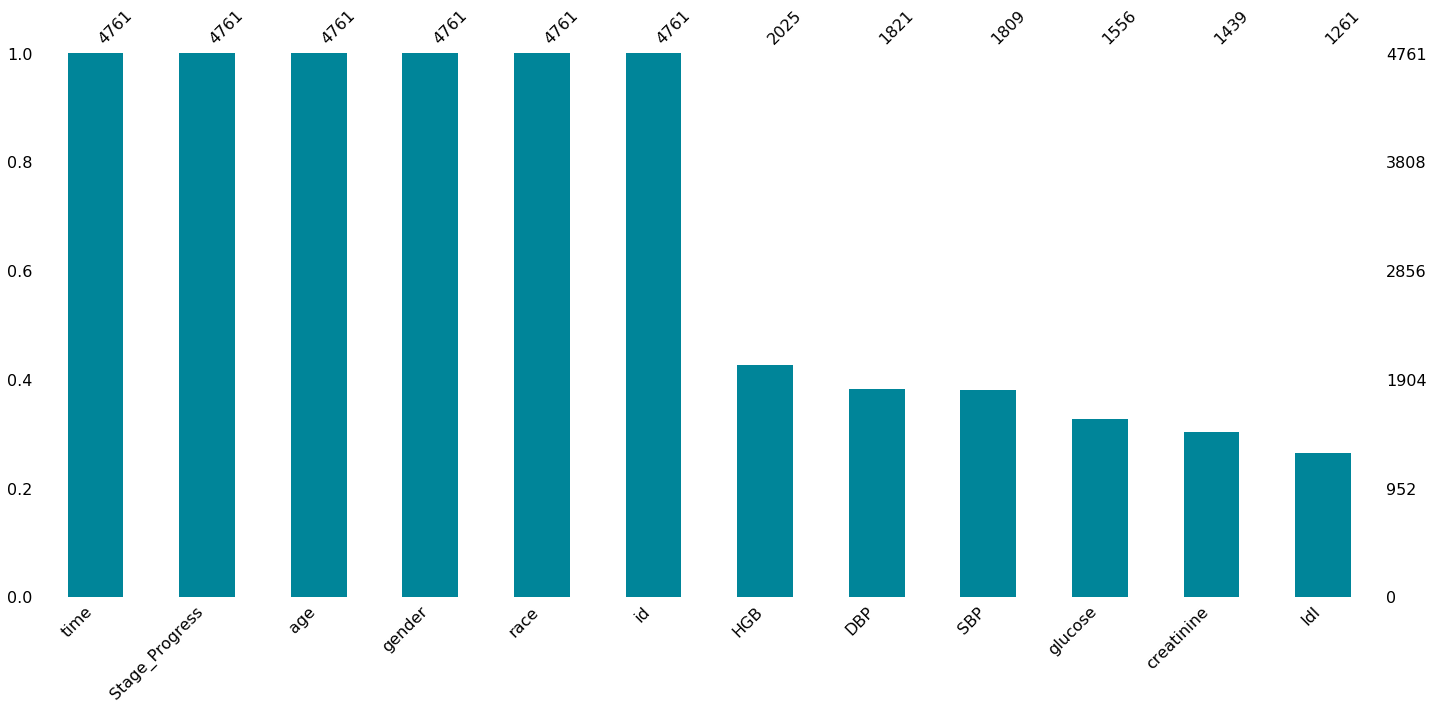

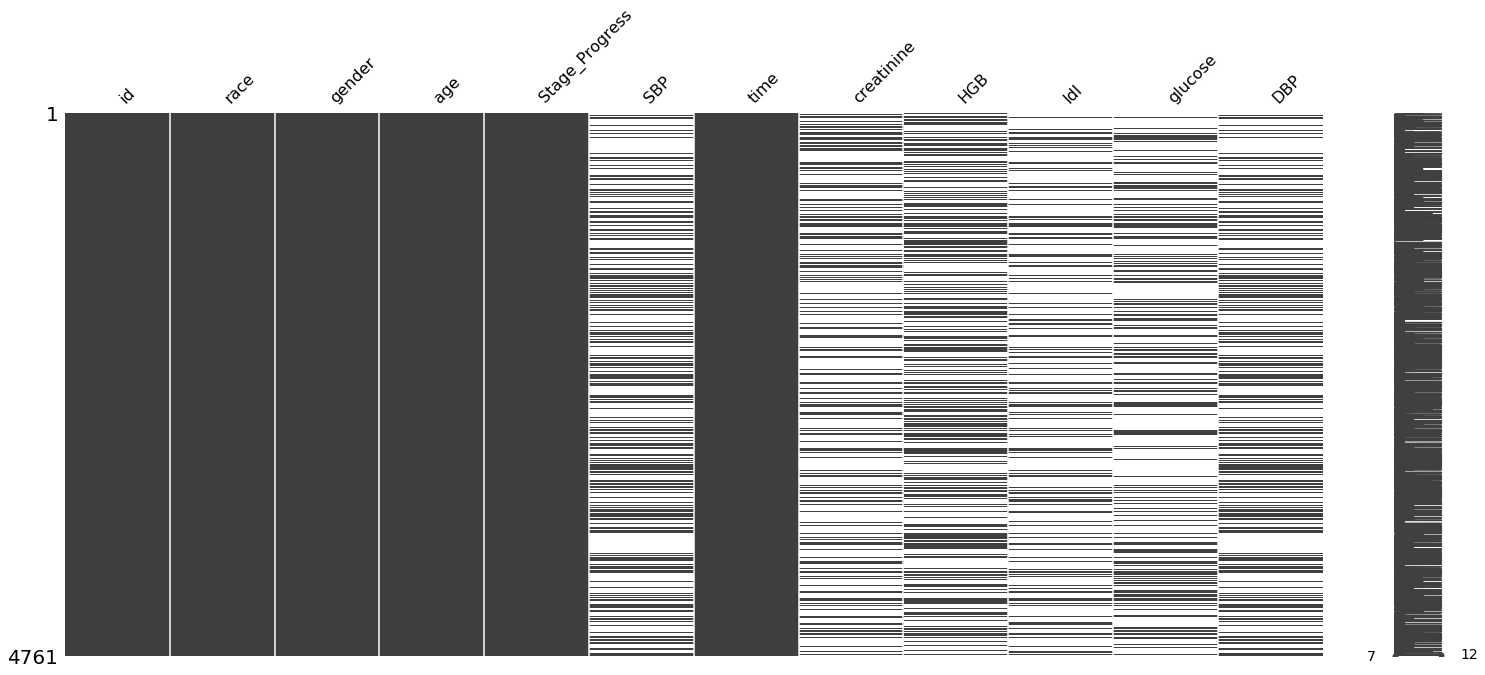

In [10]:
# missing value counts
msno.bar(df_patientMeasure,sort='descending',color='#008599')
plt.show()

msno.matrix(df_patientMeasure)
plt.show()

Most of the measurement values are extremely sparsed, patients generally only make measurements on some of the days.  

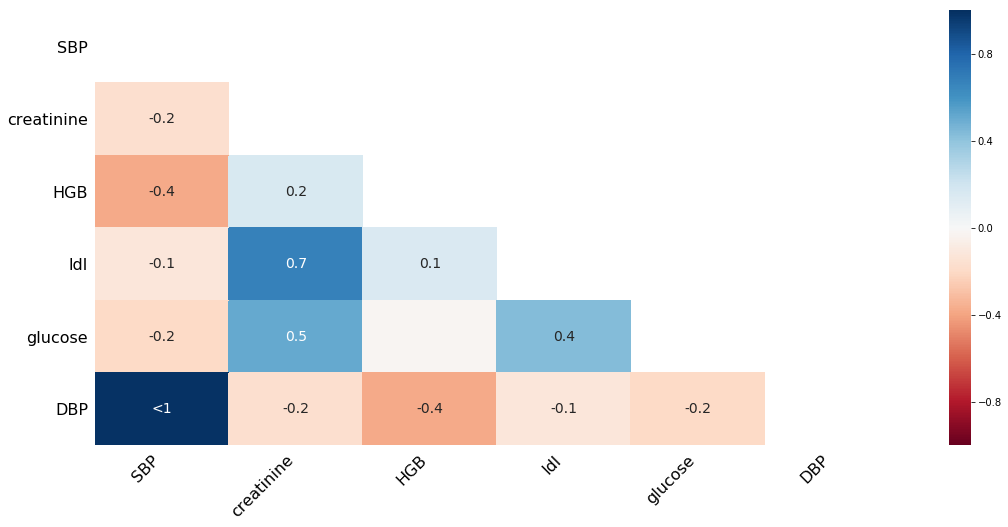

In [11]:
# missing value heat map
msno.heatmap(df_patientMeasure, figsize=(18,8))
plt.savefig('test.png', dpi = 300)
plt.show()

It is quite logical than the missing value of DBP and SBP and highly correlated, because the measurement often comes in pair.  

## Drug Consumption  

In [20]:
df_patientMed = csv_all['T_meds.csv']
display(df_patientMed.head())
display(df_patientMed.shape)

,id,drug,daily_dosage,start_day,end_day
0,0,atorvastatin,10.0,19,109
1,0,atorvastatin,10.0,117,207
2,0,losartan,100.0,19,289
3,0,losartan,100.0,403,493
4,0,losartan,100.0,587,677


(2181, 5)

In [21]:
df_patientMed[df_patientMed.start_day < 0]

,id,drug,daily_dosage,start_day,end_day
180,20,simvastatin,10.0,-54,36
217,26,olmesartan,40.0,-11,19
327,41,losartan,50.0,-8,82
331,41,metformin,500.0,-13,17
584,72,metoprolol,100.0,-1,89
588,72,simvastatin,40.0,-1,89
807,101,losartan,100.0,-16,14
808,101,losartan,100.0,-16,14
812,101,metformin,500.0,-16,14
990,129,metformin,1000.0,-2,28


There is drug consumption before they enter the experiments

Text(0.5, 0.98, 'Distribution of Drug Dosage')

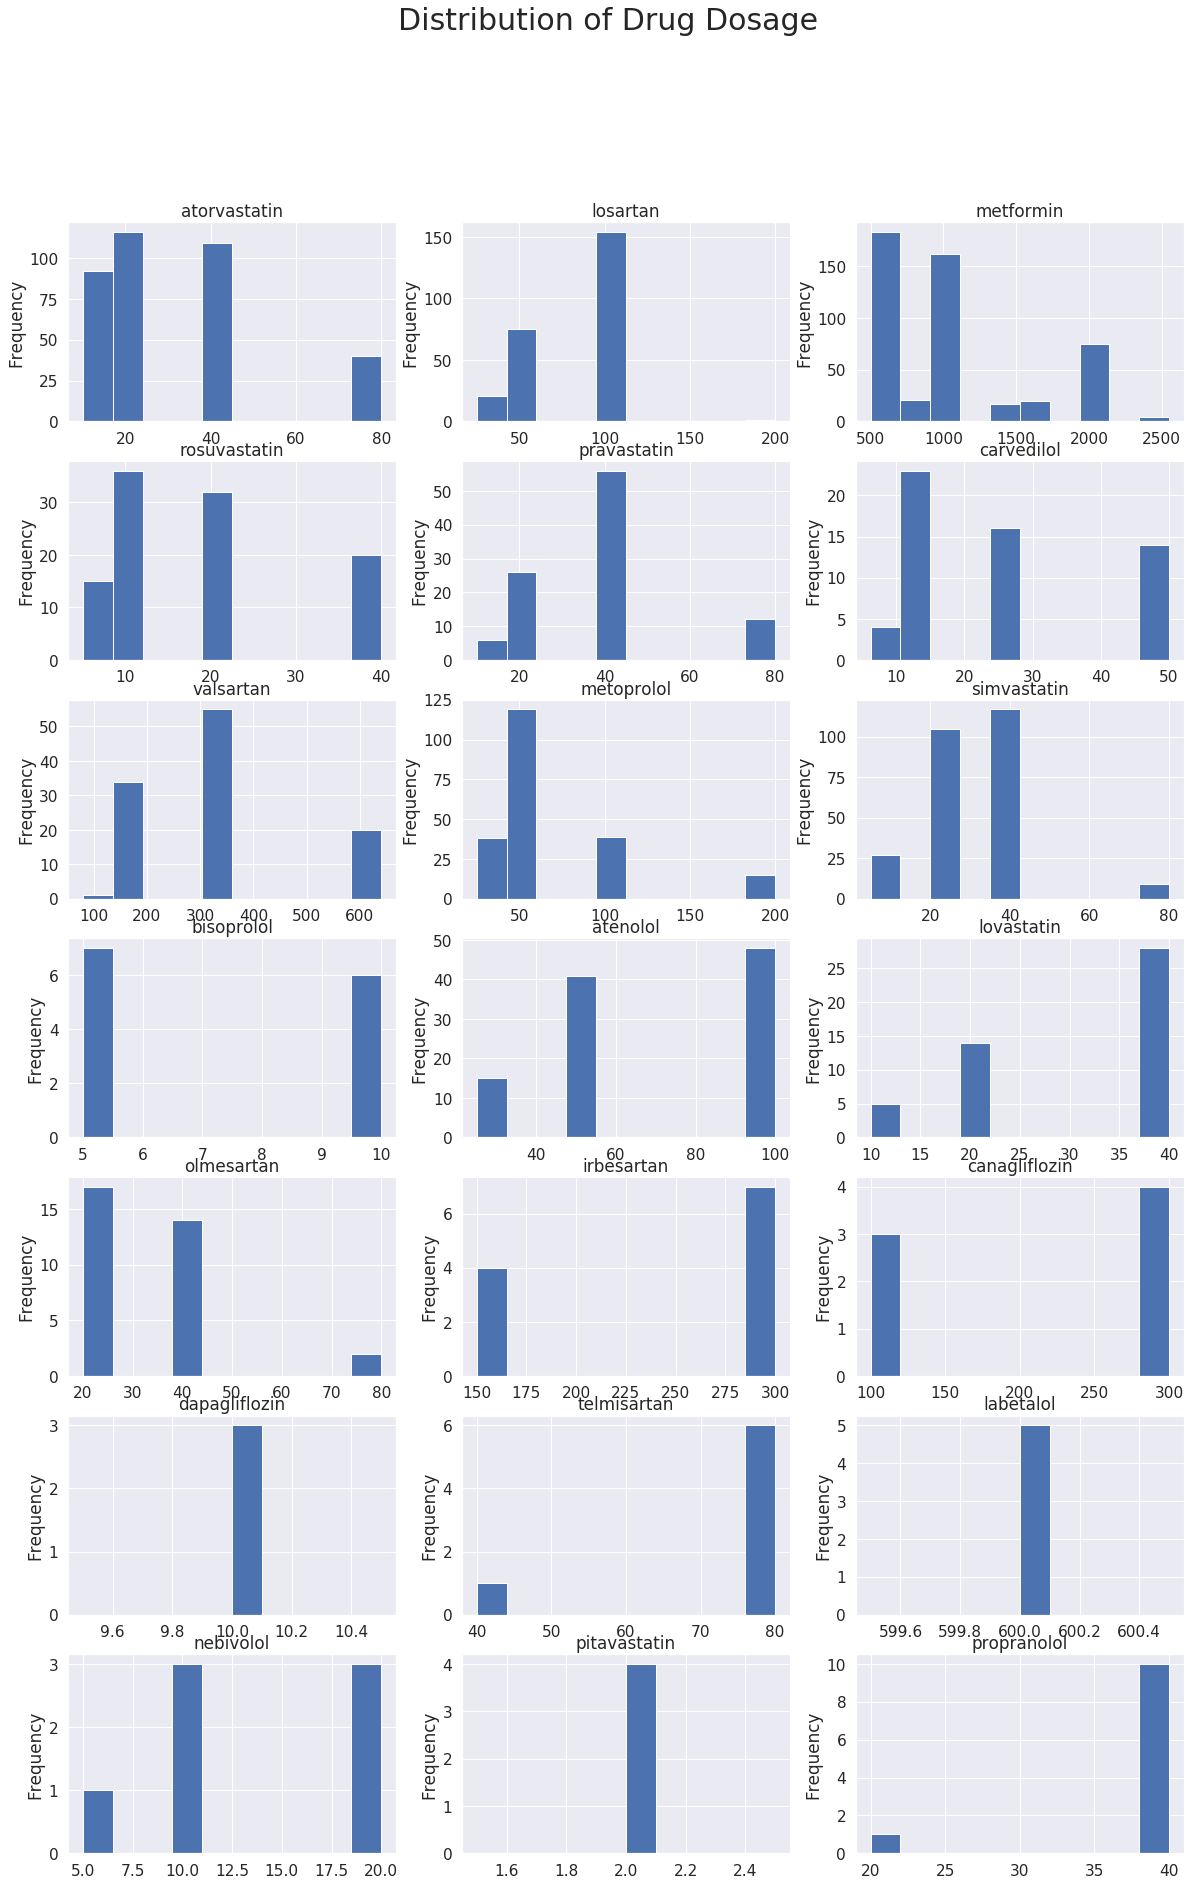

In [146]:
types_of_drug = df_patientMed.drug.unique()
count_of_drug = len(types_of_drug)


plt.figure(figsize=(20, 30))
count = 1
for drug in types_of_drug:
    plt.subplot(ceil(count_of_drug/3), 3, count)
    df_patientMed[df_patientMed.drug == drug].daily_dosage.plot(kind = 'hist')
    plt.title(drug)
    count += 1
plt.suptitle('Distribution of Drug Dosage', size = 30)

Drug consumption is a special data that is valid across a range of days. I want to know the type and dose of drug consumed by a patient on each displayed day.  

This is hard because there are too many different type of Drugs, putting each drug as a dummy variable will be too impractical, complicating the data unneccessarily.   

We can also tell from the above visualisation that drug prescription changes from drug to drug, patients to patients, hence, in order to know if the prescribed amount is considered high or low, we can only compare the amount prescribed amongst itself. Hence **normalised the prescription amount** will help us know if the prescription amount is heavy dose or normal dose.    

In [9]:
# normalisation dont work
# because if there are some patients taking the lowest level of dosage
# normalisation will take it as zero in-take

# standardisation also wont work, because it is will lead to zero result, 
# which will confuse will patients who does not consume drug

In [22]:
def percentile_calculator(base: pd.DataFrame, 
                          groupby: str, 
                          percentileof: str) -> typing.Callable:
    '''
    return a calculator that is to
    calculate the percentile of a column
    
    The column is broken down into different groups
    basically simulating: df.groupby(field).transform(find_percentile)
    
    a `groupby` can be "drug", "gender"
    '''
    calculate_cache = {}
    
    
    def transform_percentile(group: str, field_value: float) -> float:
        '''
        calculate the percentile of field_value in the group
        '''
        
        
        if group not in calculate_cache:
            calculate_cache[group] = {}
            
        if field_value in calculate_cache[group]:
            return calculate_cache[group][field_value]
        else:
            group_values = base.loc[base[groupby] == group, percentileof]
            rank = sum([1 for i in group_values if i <= field_value])
            percentile = rank/len(group_values)
            calculate_cache[group][field_value] = percentile
            return percentile
    return transform_percentile
            
percentile_in_drug = percentile_calculator(df_patientMed, 'drug', 'daily_dosage')

In [23]:
df_patientMed['daily_dosage_percentile'] = df_patientMed.apply(lambda x: percentile_in_drug(x.drug, x.daily_dosage), axis = 1)
df_patientMed[df_patientMed.drug == 'atorvastatin'].sort_values(['drug','daily_dosage'])
df_patientMed.head()

,id,drug,daily_dosage,start_day,end_day,daily_dosage_percentile
0,0,atorvastatin,10.0,19,109,0.257703
1,0,atorvastatin,10.0,117,207,0.257703
2,0,losartan,100.0,19,289,0.996016
3,0,losartan,100.0,403,493,0.996016
4,0,losartan,100.0,587,677,0.996016


The drug percentile is hoped to reflect the relative strength of the dosage specific to the drug.  

## Medical 101  

<br>
<hr>
<br>

### Creatinine  

Creatinine is a **waste product** produced by muscles from the breakdown of a compound called creatine. Creatinine is **removed from the body by the kidneys**, which filter almost all of it from the blood and release it into the urine. This test measures the amount of creatinine in the blood and/or urine.

Elevated creatinine level  signifies  **impaired kidney function** or kidney disease. As the kidneys become impaired for any reason, the creatinine level in the blood will rise due to poor clearance of creatinine by the kidneys. Abnormally high levels of creatinine thus warn of possible malfunction or failure of the kidneys.  
 
 ### DBP/SBP  

* Diastolic Blood Pressure  
* Systolic Blood Pressure  

Renal function in CKD patients is affected by **low or high SBP either side of 100 mm of Hg**, whereas **DBP affects renal function primarily when it is lower than 75 mm of Hg**. DBP should be given careful consideration so as not to lower it too aggressively while managing hypertension in CKD patients. 

### Glucose  

**When kidneys fail**, urea that builds up in the blood can **cause diabetes**, concludes a study published today in the Journal of Clinical Investigation. "We identified molecular mechanisms that may be responsible for increased blood glucose levels in patients with non-diabetic chronic kidney disease.  

### HGB

Hemoglobin (Hgb) is the protein in red blood cells that carries oxygen from the lungs to the cells of the body.  

When kidneys are healthy, they make a hormone called erythropoietin, or EPO.  This hormone helps the bone marrow to produce the amount of red blood cells (RBC) that the body needs to carry oxygen to vital organs. When the **kidneys are damaged**, they often **do not make enough EPO**.  As a result, the bone marrow makes too few red blood cells.

### LDL

If you have a high LDL level, this means that you have too much LDL cholesterol in your blood. This extra LDL, along with other substances, forms plaque. The plaque builds up in your arteries; this is a condition called atherosclerosis.  

In people with **chronic kidney disease (CKD)**, heart and **blood vessel disease is very common**.  


<br>
<hr>
<br>

Field | (Low, | Normal | ,High) | unit | Context  
-- | -- |-- |-- |--| --    
Creatining | 65 | 100  | 120 | micromoles/L | High is bad    
Diastolic Blood Pressure | 60 | 70 | 80 | mm Hg | High is bad
Systolic Blood Pressure | 100 | 120 | 140 | mm Hg | Both is bad  
Glucose | 4.0 | 7.8 | 11.1 | mmol/L | High is bad  
HBG | 13.5 | 15.5 | 17.5 | g/dL | Low is bad  
LDL | 100 | 120 | 130 | mg/dL | High is bad  

## Patient Demographic  

Text(0, 0.5, 'Count')

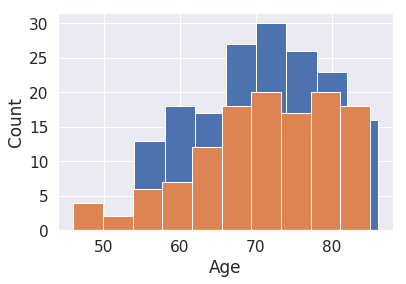

In [140]:
# plt.plot(model_data['time'], model_data['loss'], "-", label = model_name)
df_patients.groupby('gender').age.hist()
plt.xlabel("Age")
plt.ylabel("Count")


## Visualisation in Tableau  

In [15]:
df_patientMeasure.to_csv(os.path.join(path_data, 'df_patientMeasure.csv'), index = False)

In [16]:
df_patientMed.drug.unique()

array(['atorvastatin', 'losartan', 'metformin', 'rosuvastatin',
       'pravastatin', 'carvedilol', 'valsartan', 'metoprolol',
       'simvastatin', 'bisoprolol', 'atenolol', 'lovastatin',
       'olmesartan', 'irbesartan', 'canagliflozin', 'dapagliflozin',
       'telmisartan', 'labetalol', 'nebivolol', 'pitavastatin',
       'propranolol'], dtype=object)

Text(0.5, 1.0, 'Distribution of Participation Duration')

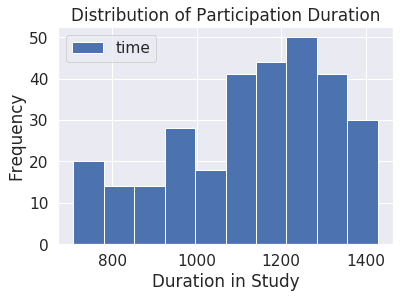

In [138]:
time_dist = df_patientMeasure.groupby('id').agg({
    'time':lambda time: time.max() - time.min()
})

time_dist.plot.hist()
plt.xlabel('Duration in Study')
plt.title("Distribution of Participation Duration")

Text(0.5, 0.98, 'Number of measurement taken for each patient')

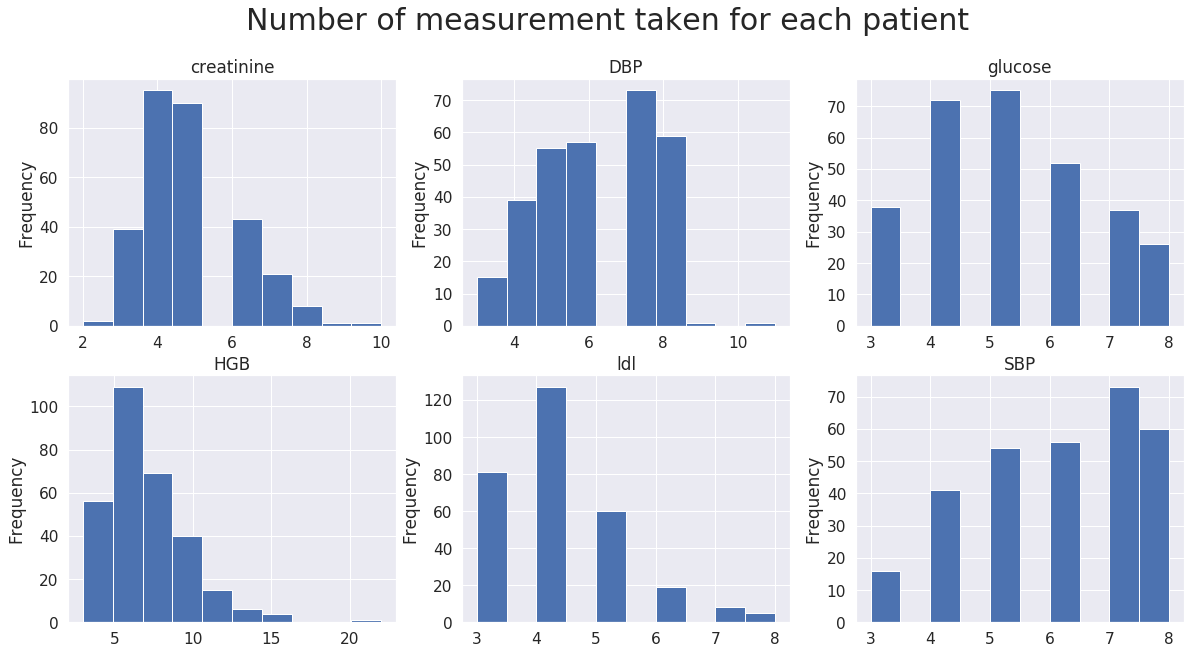

In [143]:
record_dist = df_patientMeasure.groupby('id').agg(lambda x: sum(~x.isna()))

plt.figure(figsize=(20, 10))

count = 1
for mea in measurements:
    plt.subplot(2, 3, count)
    record_dist[mea].plot.hist()
    plt.title(mea)
    count += 1
plt.suptitle('Number of measurement taken for each patient', size = 30)

Given that the study usually span across hundreds of days, the number of measurements taken for each value is pretty low.  

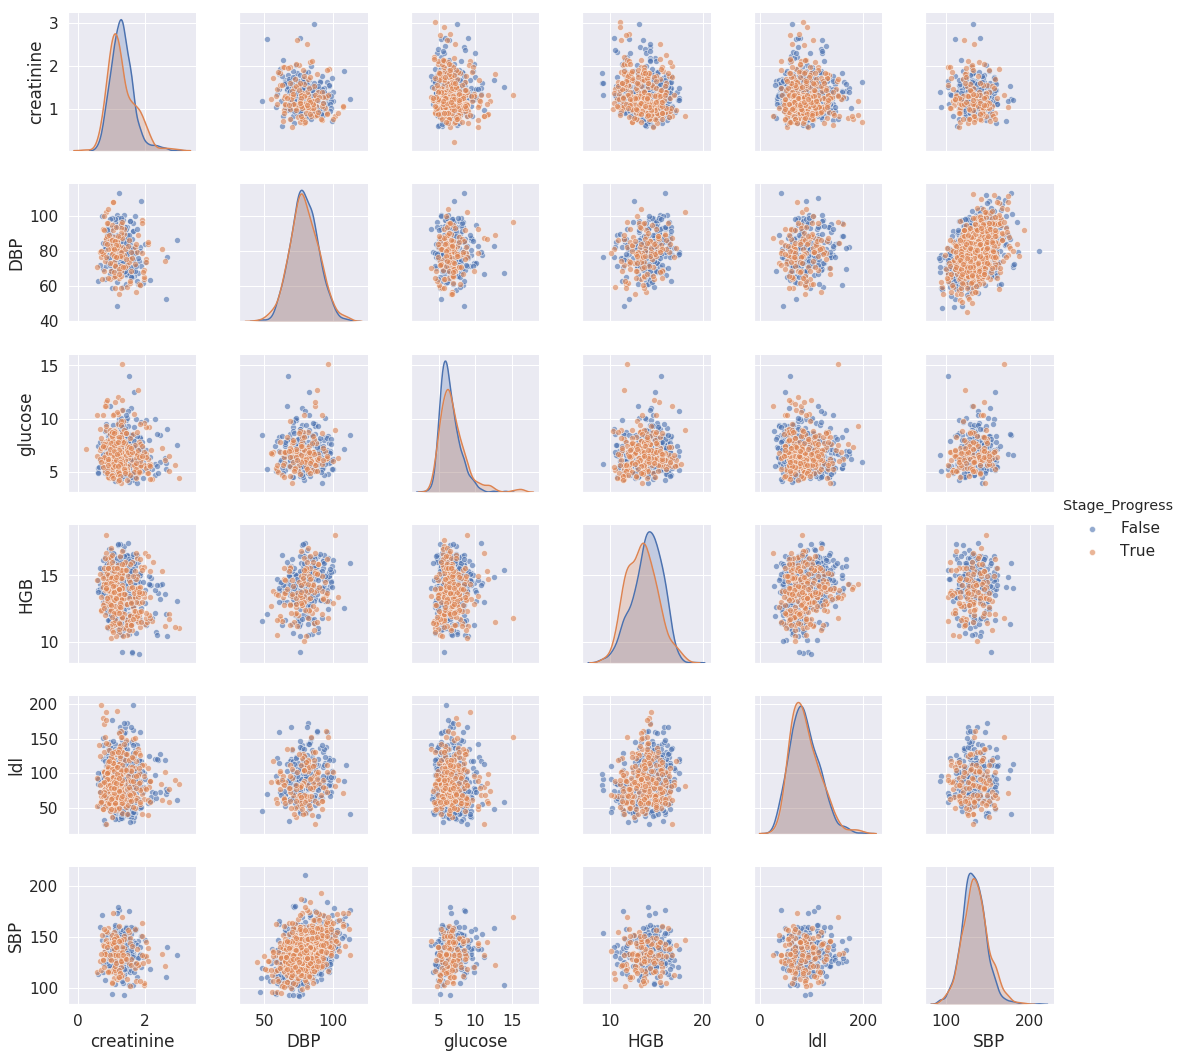

In [47]:
sns_plot = sns.pairplot(df_patientMeasure, 
             hue = 'Stage_Progress',
            vars = measurements,
            plot_kws={'alpha': 0.6})

sns_plot.savefig("output.png")

# Feature Engineering  

In [102]:
df_patientMeasure

,id,race,gender,age,Stage_Progress,creatinine,time,DBP,glucose,HGB,ldl,SBP
0,0,Unknown,Male,70,True,1.29,0,95.32,6.24,13.51,161.49,134.11
6,0,Unknown,Male,70,True,NaN,98,83.98,NaN,NaN,NaN,133.75
1,0,Unknown,Male,70,True,1.15,107,NaN,7.20,13.39,111.39,NaN
7,0,Unknown,Male,70,True,NaN,279,65.97,NaN,NaN,NaN,125.08
2,0,Unknown,Male,70,True,1.44,286,NaN,7.01,12.84,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4755,299,Asian,Male,84,False,NaN,621,72.52,NaN,NaN,NaN,113.38
4749,299,Asian,Male,84,False,0.82,652,NaN,NaN,NaN,NaN,NaN
4757,299,Asian,Male,84,False,NaN,659,NaN,6.20,14.43,79.02,NaN
4758,299,Asian,Male,84,False,NaN,1069,NaN,NaN,14.90,NaN,NaN


In [61]:
df_patientMed

,id,drug,daily_dosage,start_day,end_day,daily_dosage_percentile
0,0,atorvastatin,10.0,19,109,0.257703
1,0,atorvastatin,10.0,117,207,0.257703
2,0,losartan,100.0,19,289,0.996016
3,0,losartan,100.0,403,493,0.996016
4,0,losartan,100.0,587,677,0.996016
...,...,...,...,...,...,...
2176,299,losartan,100.0,144,174,0.996016
2177,299,losartan,100.0,461,491,0.996016
2178,299,losartan,100.0,497,527,0.996016
2179,299,losartan,100.0,529,559,0.996016


The two dataframes above are the main dataframes that will be used for the analysis.  

The general approach is to try to generate a set of attributes that describes each patient, then this set of attributes that describes them shall be inputted into some models to predict their disease progress.  

<br>
<hr>
<br>


Features that are postulated to be helpful are as follows:  

* Race (White VS Non-White)
* Gender
* Age
* Total number of measurements available from the client
* Total participation duration
* Avg number of measurement  
<br>
* For each health status measurement
    * min
    * max
    * mean
    * median
    * sd
    * trend  
<br>  
* Types of drug consumed
* Count of drug consumed
* Number of treatment session
* Total days of treatment session
* Total days in non-treatment  
<br>
* Measurements before and after treatment



<br>
<hr>
<br>  

In general, most of the categorical classess shall be one-hot converted, while numerical values shall be normalised to range = [0, 1]   

There might be too many features since we have only 300 patients to work on, but we can subsequently conduct feature selection to filter the features and reduce the dimension.  

<br>
<hr>
<br>

Generate some simple features first, split-Train Test, then evaluate the models with Simple features as benchmark to see if the method is feasible.  

In [24]:
df_patientMeasureNormed = df_patientMeasure.copy()
df_patientMeasureNormed[measurements] = df_patientMeasureNormed[measurements].transform(normalised)

## Demographic & Health Measurements  

In [25]:
def basic_package(patienMeasurements: pd.DataFrame) -> pd.DataFrame:
    '''
    for each patient,
    compute:
        Race        -> 1 == White, 0 == Non-White
        Gender      -> 1 == Male,  0 == Female
        Age         -> Age of Patient,      Normalised to [0, 1]
        StudyDur    -> Days Spend in Study, Normalised  
    '''

    df = patienMeasurements.groupby(['id', 'race', 'gender', 'age']).agg({
        'time': lambda time: time.max() - time.min()
    })
    df = df.reset_index()
    df.columns = ['ID', 'RACE', 'GENDER', 'AGE', 'STUDY_DUR']
    
    df.RACE = df.RACE.apply(lambda race: 1 if race == 'White' else 0)
    df.GENDER = df.GENDER.apply(lambda gender: 1 if gender == 'Male' else 0)
    df.AGE = df.AGE.transform(normalised)
    df.STUDY_DUR = df.STUDY_DUR.transform(normalised)
    return df

In [26]:
def agg_a_patient(eachPatient: pd.DataFrame) -> pd.Series:
    result = {}
    measurement_count = 0
    for mea in measurements:
    # for each measurement, compute its statistics
        
        mea_data = eachPatient[mea]
        
        non_null_count = sum(~mea_data.isnull())
        measurement_count += non_null_count
        
        non_null_data = mea_data[~mea_data.isnull()]
        if non_null_count >= 4:
            final = non_null_data.iloc[-2:].mean()
            initial = non_null_data.iloc[:2].mean()
        else:
            final = non_null_data.iloc[-1]
            initial = non_null_data.iloc[0]
            
        result[mea+'_deltaAvg'] = non_null_data.diff().mean()
        result[mea+'_deltaLatest'] = non_null_data.diff().iloc[-1]
            
        result[mea+'_delta'] = final - initial
        
        result[mea+'_max'] = mea_data.max()
        result[mea+'_min'] = mea_data.min()
        result[mea+'_mean'] = mea_data.mean()
    result['MEASURE_CNT'] = measurement_count
    return pd.Series(result)

def measurements_agg(patienMeasurements:pd.DataFrame) -> pd.DataFrame:
    '''
    For measurement of each patient,
    compute:
        Max
        Mean
        Min
        Delta         -> The change in this measurement during the study
        MEASURE_CNT   -> Number of measurements taking during the study
        
    '''
    
    df = patienMeasurements.groupby('id').apply(agg_a_patient)
    df.reset_index(inplace = True)
    df.rename(columns = {'id': 'ID'}, inplace = True)
    return df

In [27]:
stats_demo = basic_package(df_patientMeasureNormed).sort_values('ID')
# full_input

In [28]:
stats_measurement = measurements_agg(df_patientMeasureNormed)
# measurement_stats

In [29]:
full_input = pd.merge(stats_demo, stats_measurement,
                      on ='ID', how = 'outer')
full_input.set_index('ID',inplace = True)

In [30]:
display(full_input.head())
display(full_input.shape)

,RACE,GENDER,AGE,STUDY_DUR,creatinine_deltaAvg,creatinine_deltaLatest,creatinine_delta,creatinine_max,creatinine_min,creatinine_mean,...,ldl_max,ldl_min,ldl_mean,SBP_deltaAvg,SBP_deltaLatest,SBP_delta,SBP_max,SBP_min,SBP_mean,MEASURE_CNT
ID,,,,,,,,,,,,,,,,,,,,,
0,0,1,0.600,0.676838,-0.004317,0.053957,-0.023381,0.431655,0.302158,0.358513,...,0.784915,0.494463,0.681160,0.016061,-0.056927,0.142401,0.528296,0.277834,0.399832,40.0
1,1,0,0.625,0.951456,0.041367,0.212230,0.043165,0.705036,0.492806,0.574820,...,0.421068,0.263552,0.326535,-0.010915,-0.051217,-0.023636,0.549706,0.384215,0.489025,36.0
2,1,0,0.275,0.757282,-0.027878,0.071942,-0.035971,0.816547,0.593525,0.694245,...,0.353876,0.205925,0.285137,0.009992,-0.094878,0.031906,0.468262,0.343409,0.404870,27.0
3,1,1,0.700,0.979196,0.014388,0.003597,-0.053957,0.399281,0.179856,0.271942,...,0.488086,0.317120,0.418262,-0.006409,-0.050462,0.005584,0.477750,0.245340,0.399652,40.0
4,1,0,0.100,0.515950,-0.029496,-0.043165,-0.080935,0.399281,0.248201,0.327338,...,0.266276,0.165285,0.230781,0.052715,-0.061293,0.207683,0.686482,0.308900,0.576634,36.0


(300, 41)

## Drug Consumption Information  

In [33]:
df_patientMed.head()

,id,drug,daily_dosage,start_day,end_day,daily_dosage_percentile
0,0,atorvastatin,10.0,19,109,0.257703
1,0,atorvastatin,10.0,117,207,0.257703
2,0,losartan,100.0,19,289,0.996016
3,0,losartan,100.0,403,493,0.996016
4,0,losartan,100.0,587,677,0.996016


In [34]:
print(df_patientMed.drug.unique())
print(len(df_patientMed.drug.unique()), 'days')

['atorvastatin' 'losartan' 'metformin' 'rosuvastatin' 'pravastatin'
 'carvedilol' 'valsartan' 'metoprolol' 'simvastatin' 'bisoprolol'
 'atenolol' 'lovastatin' 'olmesartan' 'irbesartan' 'canagliflozin'
 'dapagliflozin' 'telmisartan' 'labetalol' 'nebivolol' 'pitavastatin'
 'propranolol']
21 days


There are 21 types of Drugs used by all the patients, converting the type of drug used by each patient into One-Hot Encoded will explode the number of variables.  

A strategy is to convert each type of drug into its summary statistics, for each drug:
* find its ranking in terms of its "effectiveness", call it  **DRUG_STRENGTH**
* find the number of patients taking this drug, call it **DRUG_POPULARITY**

In [34]:
df_patientPrescription = pd.merge(df_patients[['id', 'Stage_Progress']], df_patientMed,
         on = 'id', how = 'outer')

def curing_percentage(drug_progress):
    drug_stat = {}
    
    cured = len(drug_progress[drug_progress.Stage_Progress == False].id.unique())
    allppl = len(drug_progress.id.unique())
    
    
    drug_stat['DRUG_CURED'] = cured
    drug_stat['DRUG_STRENGTH'] = cured/allppl
    drug_stat['DRUG_POPULARITY'] = allppl
    drug_stat['DRUG_AVG_DOSAGE'] = drug_progress.daily_dosage_percentile.mean()
    drug_stat['DRUG_AVG_TREATMENT_DUR'] = (drug_progress.end_day - drug_progress.start_day).mean()
    
    return pd.Series(drug_stat)
    
df_drugInfo = pd.DataFrame(df_patientPrescription.groupby(['drug']).apply(curing_percentage))
# df_drugRanking.columns = ['DRUG_STRENGTH']
df_drugInfo

,DRUG_CURED,DRUG_STRENGTH,DRUG_POPULARITY,DRUG_AVG_DOSAGE,DRUG_AVG_TREATMENT_DUR
drug,,,,,
atenolol,17.0,0.653846,26.0,0.694619,97.788462
atorvastatin,77.0,0.706422,109.0,0.638883,82.064426
bisoprolol,4.0,0.800000,5.0,0.751479,87.692308
canagliflozin,3.0,0.750000,4.0,0.755102,64.285714
carvedilol,10.0,0.588235,17.0,0.653432,68.684211
dapagliflozin,2.0,1.000000,2.0,1.000000,70.000000
irbesartan,1.0,0.166667,6.0,0.768595,69.545455
labetalol,1.0,1.000000,1.0,1.000000,66.000000
losartan,50.0,0.704225,71.0,0.736369,76.549801


In [35]:
df_drugInfo.to_csv('Drug Info.csv')

In [36]:
df_patientMed.shape

(2181, 6)

In [37]:
stats_drug = pd.merge(df_patientMed, df_drugInfo,
        left_on = 'drug', 
         right_index = True, 
         how = 'outer')

display(stats_drug.head())
display(stats_drug.shape)

,id,drug,daily_dosage,start_day,end_day,daily_dosage_percentile,DRUG_CURED,DRUG_STRENGTH,DRUG_POPULARITY,DRUG_AVG_DOSAGE,DRUG_AVG_TREATMENT_DUR
0,0,atorvastatin,10.0,19,109,0.257703,77.0,0.706422,109.0,0.638883,82.064426
1,0,atorvastatin,10.0,117,207,0.257703,77.0,0.706422,109.0,0.638883,82.064426
11,1,atorvastatin,20.0,43,133,0.582633,77.0,0.706422,109.0,0.638883,82.064426
12,1,atorvastatin,20.0,96,126,0.582633,77.0,0.706422,109.0,0.638883,82.064426
13,1,atorvastatin,40.0,295,385,0.887955,77.0,0.706422,109.0,0.638883,82.064426


(2181, 11)

In [38]:
def agg_med_hist(patient: pd.DataFrame) -> pd.Series:
    '''
    taking in a patient's medical history,
    return a pd.Series describing the patient
    '''
    medical_summary = {}
    
    medical_summary['DRUG_CNT'] = len(patient.drug.unique())
    
    # cannot simply add all the treatment
    medical_summary['TREATMENT_DUR_NAIVE'] = (patient.end_day - patient.start_day).sum()
    # may have overlapping drugs
    
    # a set of integers presenting the days taking medicine
    medication_days = set()
    for drug_row in patient.itertuples():
        med_days = range(drug_row.start_day, drug_row.end_day + 1)
        medication_days.update(med_days)
        
    medical_summary['TREATMENT_DUR'] = len(medication_days)
    medication_days = sorted(list(medication_days))
    treatment_cnt = 0
    treatment_break_dur = 0
    
    while medication_days:
        treatment_cnt += 1
        this_day = medication_days.pop(0)
        
        # check if still taking medicine the next day
        while len(medication_days) > 0 and medication_days[0]-1 == this_day:
            this_day = medication_days.pop(0)
        if len(medication_days) > 0 and medication_days[0]-1 != this_day:
            # append the number days not takig medicine
            treatment_break_dur += medication_days[0] - this_day
            
    medical_summary['TREATMENTS'] = treatment_cnt
    medical_summary['TREATMENTS_RESTDAYS'] = treatment_break_dur
    
    # average treatment duration
    medical_summary['AVG_TREATMENT_DUR'] = medical_summary['TREATMENT_DUR']/medical_summary['TREATMENTS']
    
    
    dosage_each_session = (patient.end_day - patient.start_day) * patient.daily_dosage_percentile
    medical_summary['DOSAGE_TOTAL'] = dosage_each_session.sum()
    medical_summary['DOSAGE_AVG'] = medical_summary['DOSAGE_TOTAL']/medical_summary['TREATMENTS'] 
    
    for col in patient.columns:
        if 'DRUG' not in col:
            continue
        medical_summary[col+'_max'] = patient[col].max()
        medical_summary[col+'_avg'] = patient[col].mean()
    
    return pd.Series(medical_summary)
    

def drugTreatments(patientMed: pd.DataFrame) -> pd.DataFrame:
    '''
    For each patient,
    compute:
        DRUG_CNT            --> How many types of drug are consumed
        DOSAGE_TOTAL        --> Total dosage(percentile) of drug consumed, `dosage = dur * daily_dosage`
        DOSAGE_AVG          --> Average dosage(percentile) of drug consumed each treatment session
        TREATMENTS          --> How many treatment sessions were involved,
                                each treament session is defined as one continuous period with medication
        TREATMENTS_RESTDAYS --> Number of days taking a rest from medicine during treatment
        TREATMENT_DUR       --> Total number of days spent in treatment
        TREATMENT_DUR_NAIVE --> Total number of drug days
        
    '''
    
    # for each patient, find their medical history summary
    # return all patient history as a single DF
    patientMed = patientMed.groupby('id').apply(agg_med_hist)
    
    # normalised the values
    # do not normalised, otherwise it will break the data integrity with 
    # patients who does not consume any drug
    # patientMed = patientMed.transform(normalised, axis = 0)
    patientMed.reset_index(inplace = True)
    
    return patientMed
    

In [39]:
stats_medical_hist = drugTreatments(stats_drug)

# combine with patient who may not have medication history
stats_medical_hist = pd.merge(df_patients[['id']], stats_medical_hist,
         on = 'id', how = 'outer')

# fill patients with no medical history with zero values
stats_medical_hist = stats_medical_hist.fillna(0)

# set 'id' as index
stats_medical_hist.set_index('id', inplace = True)

# normalise the values
stats_medical_hist = stats_medical_hist.transform(normalised, axis = 0)

display(stats_medical_hist.head())
display(stats_medical_hist.shape)

,DRUG_CNT,TREATMENT_DUR_NAIVE,TREATMENT_DUR,TREATMENTS,TREATMENTS_RESTDAYS,AVG_TREATMENT_DUR,DOSAGE_TOTAL,DOSAGE_AVG,DRUG_CURED_max,DRUG_CURED_avg,DRUG_STRENGTH_max,DRUG_STRENGTH_avg,DRUG_POPULARITY_max,DRUG_POPULARITY_avg,DRUG_AVG_DOSAGE_max,DRUG_AVG_DOSAGE_avg,DRUG_AVG_TREATMENT_DUR_max,DRUG_AVG_TREATMENT_DUR_avg
id,,,,,,,,,,,,,,,,,,
0,0.6,0.447917,0.948148,0.181818,0.036765,0.474074,0.415434,0.216693,1.000000,0.861865,0.706422,0.654358,1.000000,0.883229,0.736369,0.667527,0.839204,0.794325
1,0.2,0.104167,0.404444,0.272727,0.314338,0.134815,0.095852,0.033331,1.000000,1.000000,0.706422,0.706422,0.939655,0.939655,0.638883,0.638883,0.839204,0.839204
2,0.2,0.062500,0.269630,0.181818,0.503676,0.134815,0.037184,0.019395,0.298701,0.298701,0.741935,0.741935,0.267241,0.267241,0.638797,0.638797,0.830801,0.830801
3,0.2,0.125000,0.521481,0.272727,0.209559,0.173827,0.038705,0.013459,1.000000,1.000000,0.706422,0.706422,0.939655,0.939655,0.638883,0.638883,0.839204,0.839204
4,0.6,0.562500,0.914074,0.181818,0.042279,0.457037,0.509288,0.265648,0.922078,0.526696,0.704225,0.566867,1.000000,0.576628,0.736369,0.688789,0.890391,0.831395


(300, 18)

## input_ver2  

Version 2 will include medication data and some minor changes.  

There are simply too overwhelming amount of White race in the dataset, it is likely to cause some highly biased result due to over-fitting to the race variable. Hence the race variable should be removed in the model to reduce such influence.    

In [40]:
full_input_v2 = pd.merge(full_input, stats_medical_hist, 
         left_index=True, right_index=True, how = 'outer')
full_input_v2.head()

,RACE,GENDER,AGE,STUDY_DUR,creatinine_deltaAvg,creatinine_deltaLatest,creatinine_delta,creatinine_max,creatinine_min,creatinine_mean,...,DRUG_CURED_max,DRUG_CURED_avg,DRUG_STRENGTH_max,DRUG_STRENGTH_avg,DRUG_POPULARITY_max,DRUG_POPULARITY_avg,DRUG_AVG_DOSAGE_max,DRUG_AVG_DOSAGE_avg,DRUG_AVG_TREATMENT_DUR_max,DRUG_AVG_TREATMENT_DUR_avg
ID,,,,,,,,,,,,,,,,,,,,,
0,0,1,0.600,0.676838,-0.004317,0.053957,-0.023381,0.431655,0.302158,0.358513,...,1.000000,0.861865,0.706422,0.654358,1.000000,0.883229,0.736369,0.667527,0.839204,0.794325
1,1,0,0.625,0.951456,0.041367,0.212230,0.043165,0.705036,0.492806,0.574820,...,1.000000,1.000000,0.706422,0.706422,0.939655,0.939655,0.638883,0.638883,0.839204,0.839204
2,1,0,0.275,0.757282,-0.027878,0.071942,-0.035971,0.816547,0.593525,0.694245,...,0.298701,0.298701,0.741935,0.741935,0.267241,0.267241,0.638797,0.638797,0.830801,0.830801
3,1,1,0.700,0.979196,0.014388,0.003597,-0.053957,0.399281,0.179856,0.271942,...,1.000000,1.000000,0.706422,0.706422,0.939655,0.939655,0.638883,0.638883,0.839204,0.839204
4,1,0,0.100,0.515950,-0.029496,-0.043165,-0.080935,0.399281,0.248201,0.327338,...,0.922078,0.526696,0.704225,0.566867,1.000000,0.576628,0.736369,0.688789,0.890391,0.831395


In [173]:
pd.merge(df_patients[['id', 'Stage_Progress']], full_input_v2,
        left_on = 'id', right_index=True, how = 'outer').to_csv('CKD_fullinput.csv')
full_input_v2.columns

Index(['RACE', 'GENDER', 'AGE', 'STUDY_DUR', 'creatinine_deltaAvg',
       'creatinine_deltaLatest', 'creatinine_delta', 'creatinine_max',
       'creatinine_min', 'creatinine_mean', 'DBP_deltaAvg', 'DBP_deltaLatest',
       'DBP_delta', 'DBP_max', 'DBP_min', 'DBP_mean', 'glucose_deltaAvg',
       'glucose_deltaLatest', 'glucose_delta', 'glucose_max', 'glucose_min',
       'glucose_mean', 'HGB_deltaAvg', 'HGB_deltaLatest', 'HGB_delta',
       'HGB_max', 'HGB_min', 'HGB_mean', 'ldl_deltaAvg', 'ldl_deltaLatest',
       'ldl_delta', 'ldl_max', 'ldl_min', 'ldl_mean', 'SBP_deltaAvg',
       'SBP_deltaLatest', 'SBP_delta', 'SBP_max', 'SBP_min', 'SBP_mean',
       'MEASURE_CNT', 'DRUG_CNT', 'TREATMENT_DUR_NAIVE', 'TREATMENT_DUR',
       'TREATMENTS', 'TREATMENTS_RESTDAYS', 'AVG_TREATMENT_DUR',
       'DOSAGE_TOTAL', 'DOSAGE_AVG', 'DRUG_STRENGTH_max', 'DRUG_STRENGTH_avg',
       'DRUG_POPULARITY_max', 'DRUG_POPULARITY_avg', 'DRUG_AVG_DOSAGE_max',
       'DRUG_AVG_DOSAGE_avg', 'DRUG_AVG_TREATME

In [41]:
propective_cols = [
    'STUDY_DUR',
    'creatinine_delta', 'DBP_delta', 'glucose_delta',
    'HGB_delta', 'ldl_delta', 'SBP_delta',
    'creatinine_deltaLatest', 'DBP_deltaLatest', 'glucose_deltaLatest',
    'HGB_deltaLatest', 'ldl_deltaLatest', 'SBP_deltaLatest',
    'creatinine_deltaAvg', 'DBP_deltaAvg', 'glucose_deltaAvg',
    'HGB_deltaAvg', 'ldl_deltaAvg', 'SBP_deltaAvg',
]

## input_ver2

In [54]:
propective_cols = ['HGB_deltaAvg',
 'TREATMENT_DUR',
 'SBP_delta',
 'SBP_deltaAvg',
 'HGB_mean',
 'DRUG_AVG_DOSAGE_avg',
 'HGB_deltaLatest',
 'DBP_delta',
 'ldl_max',
 'SBP_mean',
 'glucose_deltaLatest',
 'creatinine_mean',
 'DRUG_STRENGTH_avg',
 'glucose_max',
 'glucose_delta',
 'HGB_min',
 'ldl_deltaLatest',
 'MEASURE_CNT',
 'DBP_deltaAvg',
 'DRUG_CNT',
 'creatinine_deltaAvg',
 'ldl_mean',
 'DRUG_STRENGTH_max',
 'DBP_deltaLatest',
 'ldl_delta',
 'DOSAGE_TOTAL',
 'ldl_deltaAvg',
 'DRUG_POPULARITY_avg',
 'SBP_deltaLatest',
 'glucose_mean',
 'glucose_min',
 'glucose_deltaAvg',
 'AGE',
 'SBP_max',
 'creatinine_min',
 'AVG_TREATMENT_DUR',
 'HGB_delta',
 'DBP_max']



In [55]:
sorted(propective_cols)

['AGE',
 'AVG_TREATMENT_DUR',
 'DBP_delta',
 'DBP_deltaAvg',
 'DBP_deltaLatest',
 'DBP_max',
 'DOSAGE_TOTAL',
 'DRUG_AVG_DOSAGE_avg',
 'DRUG_CNT',
 'DRUG_POPULARITY_avg',
 'DRUG_STRENGTH_avg',
 'DRUG_STRENGTH_max',
 'HGB_delta',
 'HGB_deltaAvg',
 'HGB_deltaLatest',
 'HGB_mean',
 'HGB_min',
 'MEASURE_CNT',
 'SBP_delta',
 'SBP_deltaAvg',
 'SBP_deltaLatest',
 'SBP_max',
 'SBP_mean',
 'TREATMENT_DUR',
 'creatinine_deltaAvg',
 'creatinine_mean',
 'creatinine_min',
 'glucose_delta',
 'glucose_deltaAvg',
 'glucose_deltaLatest',
 'glucose_max',
 'glucose_mean',
 'glucose_min',
 'ldl_delta',
 'ldl_deltaAvg',
 'ldl_deltaLatest',
 'ldl_max',
 'ldl_mean']

In [43]:
full_input_v3 = full_input_v2[propective_cols]

# Train-Test Split

## Simple Input without Medication Data

In [44]:
data_versions = [
    full_input,
    full_input_v2,
    full_input_v3
]

In [45]:
train_test_sets = []

for data in data_versions:
    data = train_test_split(data, df_patients.Stage_Progress,
                                                        test_size=0.2,
                                                        random_state=0,
                                                        stratify=df_patients.Stage_Progress)
    train_test_sets.append(data)

## PCA Version

About 3 components produces 99% variance explained.  

In [155]:
for x_train, x_test, y_train, y_test in train_test_sets:
    pca = PCA()
    pca.fit(x_train)

    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_[:3]))
    print('================================')

[9.80476465e-01 5.49204963e-03 3.81301388e-03 1.88990438e-03
 1.23451173e-03 1.07316927e-03 9.42896927e-04 8.24170381e-04
 6.43326853e-04 5.35599370e-04 4.97904190e-04 3.55957467e-04
 2.82970350e-04 2.51467187e-04 2.40004723e-04 1.76854274e-04
 1.66474257e-04 1.48309347e-04 1.30801875e-04 1.28709383e-04
 1.16866982e-04 1.07629863e-04 9.27464766e-05 7.36786205e-05
 6.37428823e-05 5.74206379e-05 4.75443019e-05 4.10288039e-05
 3.45198984e-05 1.30366155e-05 1.12931896e-05 8.03633513e-06
 4.59122953e-06 4.16667496e-06 3.86181423e-06 3.59373725e-06
 2.82039057e-06 2.71570261e-06 2.41929603e-06 1.97698644e-06
 1.74958350e-06]
0.9897815280206622
[8.61455314e-01 5.65556454e-02 3.43575261e-02 2.50728311e-02
 1.57727375e-02 3.62602298e-03 2.11921321e-03 7.07486489e-04
 2.32424238e-04 7.89907326e-05 1.83618751e-05 1.23298376e-06
 6.24609504e-07 4.43141800e-07 2.96802642e-07 1.46386617e-07
 9.99425840e-08 8.86727011e-08 7.66475284e-08 6.36536079e-08
 5.15666808e-08 4.26490693e-08 3.98207124e-08 2.9

In [156]:
train_test_sets_pca3 = []
for x_train, x_test, y_train, y_test in train_test_sets:
    
    pca = PCA(n_components=3)
    x_train_pca3 = pca.fit_transform(x_train)
    x_test_pca3 = pca.transform(x_test)
    train_test_sets_pca3.append((
        x_train_pca3, x_test_pca3, y_train, y_test
    ))

# Models  

## Benchmark

Simply Classify everything as True or False  

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        40
        True       0.33      1.00      0.50        20

   micro avg       0.33      0.33      0.33        60
   macro avg       0.17      0.50      0.25        60
weighted avg       0.11      0.33      0.17        60



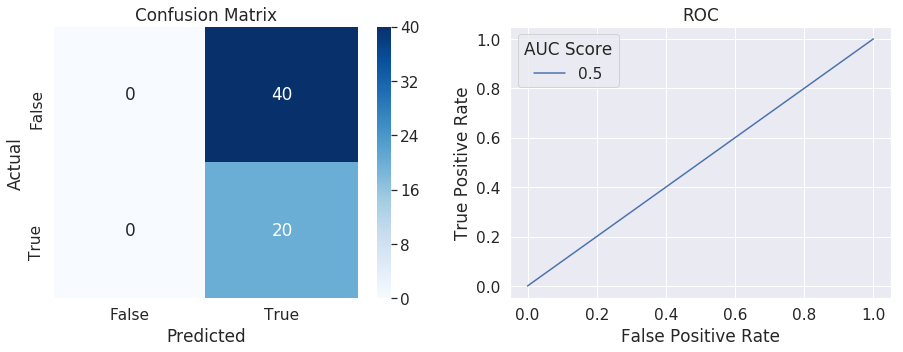

In [107]:
y_pred = pd.Series([True for i in range(len(y_test))])
y_pred_prob = pd.Series([0.5 for i in range(len(y_test))])
plotConfusionMatrix(y_test, y_pred, y_pred_prob)

              precision    recall  f1-score   support

       False       0.67      1.00      0.80        40
        True       0.00      0.00      0.00        20

   micro avg       0.67      0.67      0.67        60
   macro avg       0.33      0.50      0.40        60
weighted avg       0.44      0.67      0.53        60



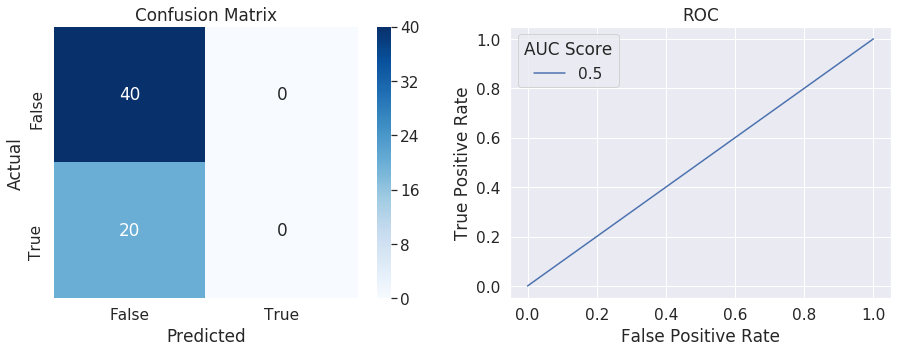

In [110]:
y_pred = pd.Series([False for i in range(len(y_test))])
y_pred_prob = pd.Series([0.5 for i in range(len(y_test))])
plotConfusionMatrix(y_test, y_pred, y_pred_prob)

## Trials

              precision    recall  f1-score   support

       False       0.73      0.90      0.81        40
        True       0.64      0.35      0.45        20

   micro avg       0.72      0.72      0.72        60
   macro avg       0.69      0.62      0.63        60
weighted avg       0.70      0.72      0.69        60

              precision    recall  f1-score   support

       False       0.76      0.88      0.81        40
        True       0.64      0.45      0.53        20

   micro avg       0.73      0.73      0.73        60
   macro avg       0.70      0.66      0.67        60
weighted avg       0.72      0.73      0.72        60



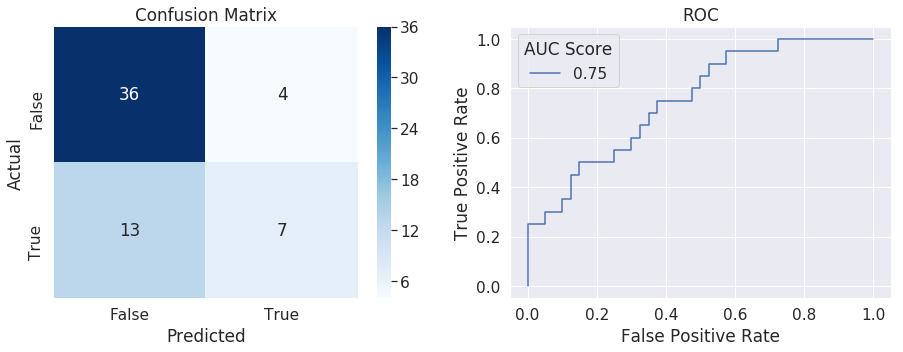

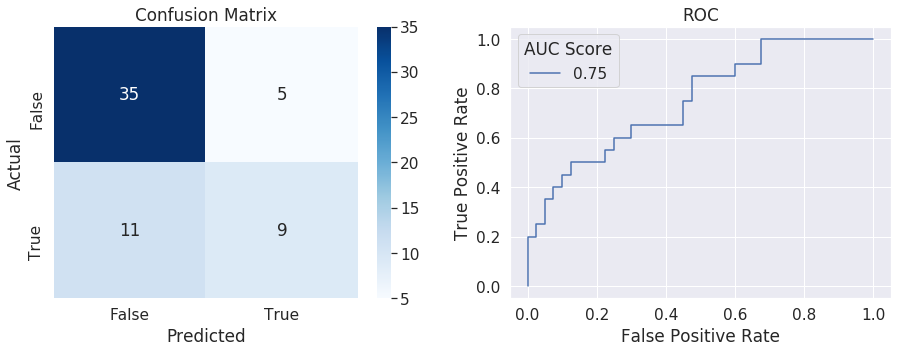

In [227]:
for x_train, x_test, y_train, y_test in train_test_sets:
    clf = LogisticRegression(random_state=0).fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)

Best parameters:
{'max_depth': 3, 'n_estimators': 17, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.79      0.95      0.86        40
        True       0.83      0.50      0.62        20

    accuracy                           0.80        60
   macro avg       0.81      0.72      0.74        60
weighted avg       0.81      0.80      0.78        60

Best parameters:
{'max_depth': 3, 'n_estimators': 12, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.76      0.95      0.84        40
        True       0.80      0.40      0.53        20

    accuracy                           0.77        60
   macro avg       0.78      0.68      0.69        60
weighted avg       0.77      0.77      0.74        60

Best parameters:
{'max_depth': 5, 'n_estimators': 11, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.83      0.88      0.85        40
        True   

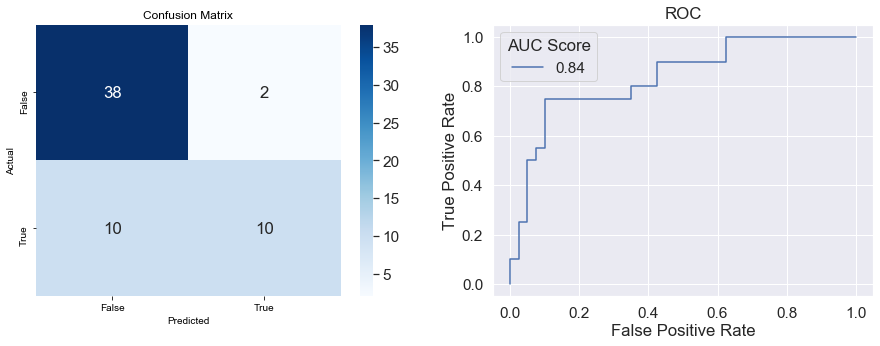

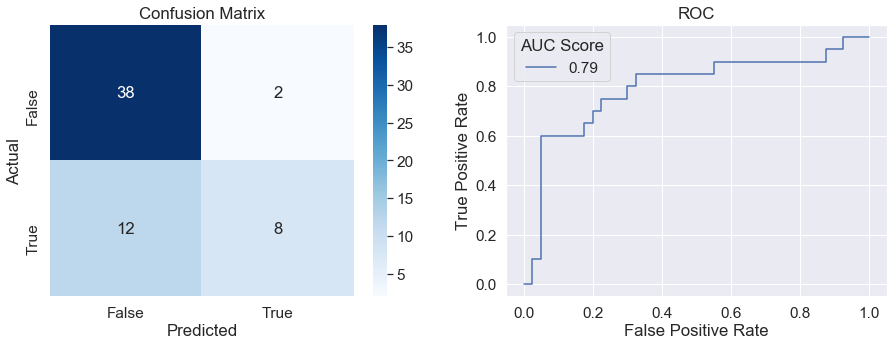

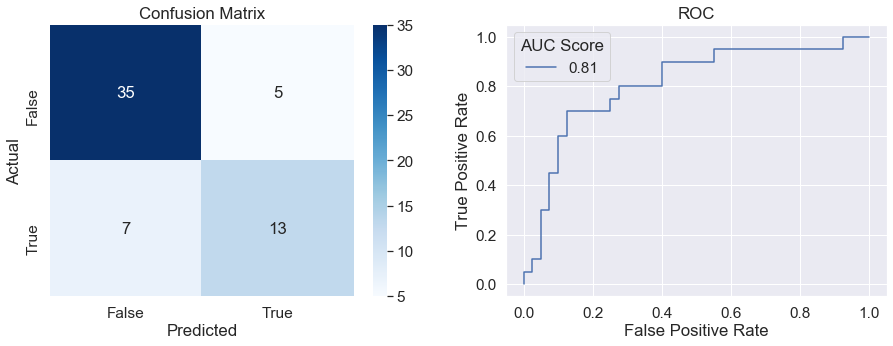

In [46]:
classifiers = []
for x_train, x_test, y_train, y_test in train_test_sets:
    
    tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16, 17, 18, 19, 20],
                         'max_depth':[2,3,4,5,6,7, 8, 9, 10, 11, None],
                         #'class_weight':[None,{0: 0.33,1:0.67}, 'balanced'],
                         'random_state':[42]}]
    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='roc_auc')
    clf.fit(x_train, y_train)
    
    best_clf = clf.best_estimator_

    y_pred = best_clf.predict(x_test)
    y_pred_prob = best_clf.predict_proba(x_test)[:,1]
    
    '''
    accuracy = 0
    decision_threshold = 0
    for threshold in range(0,100):
        threshold /= 100
        y_pred = y_pred_prob >= decision_threshold
        result = y_pred == y_test
    
        this_acc = sum(result)/len(result)
        print(this_acc)
        if this_acc >= accuracy:
            decision_threshold = threshold
            
    y_pred = y_pred_prob >= decision_threshold 
    '''
    
    classifiers.append(best_clf)
    print('Best parameters:')
    print(clf.best_params_)
    # print(f"Decision Threshold: {decision_threshold}")
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)

Best parameters:
{'max_depth': 3, 'n_estimators': 17, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.79      0.95      0.86        40
        True       0.83      0.50      0.62        20

   micro avg       0.80      0.80      0.80        60
   macro avg       0.81      0.72      0.74        60
weighted avg       0.81      0.80      0.78        60

Best parameters:
{'max_depth': 3, 'n_estimators': 15, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.75      0.97      0.85        40
        True       0.88      0.35      0.50        20

   micro avg       0.77      0.77      0.77        60
   macro avg       0.81      0.66      0.67        60
weighted avg       0.79      0.77      0.73        60

Best parameters:
{'max_depth': 5, 'n_estimators': 11, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.83      0.88      0.85        40
        True   

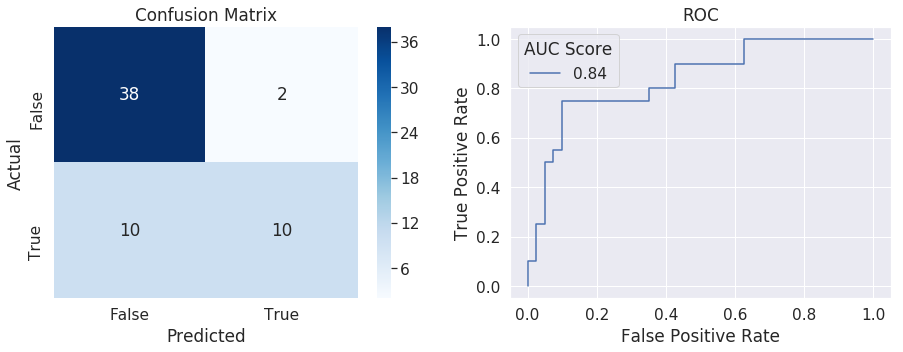

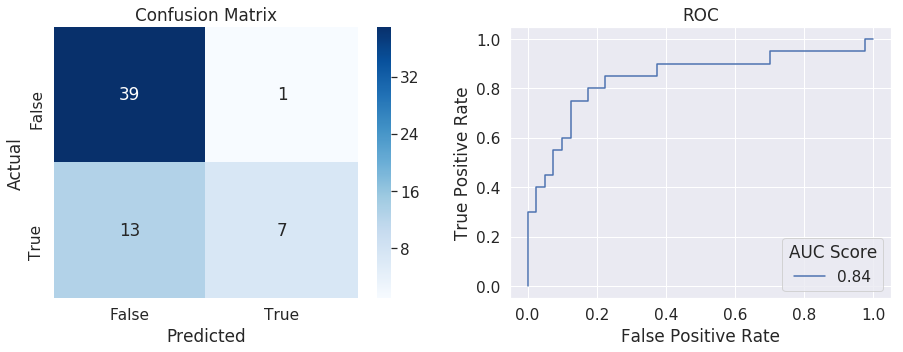

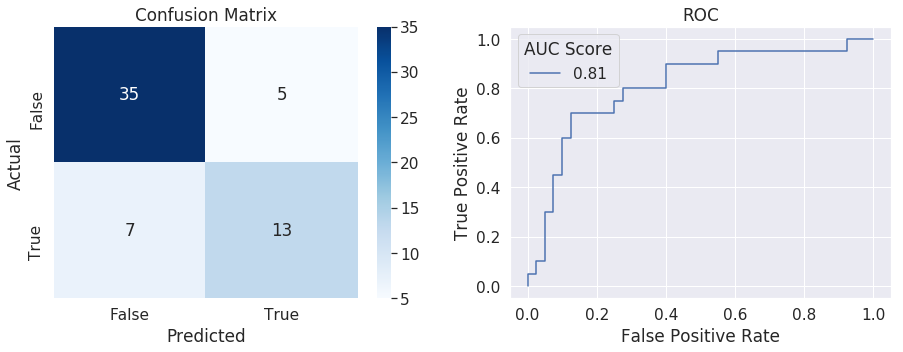

In [160]:
classifiers = []
for x_train, x_test, y_train, y_test in train_test_sets:
    
    tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16, 17, 18, 19, 20],
                         'max_depth':[2,3,4,5,6,7, 8, 9, 10, 11, None],
                         #'class_weight':[None,{0: 0.33,1:0.67}, 'balanced'],
                         'random_state':[42]}]
    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='roc_auc')
    clf.fit(x_train, y_train)
    
    best_clf = clf.best_estimator_

    y_pred = best_clf.predict(x_test)
    y_pred_prob = best_clf.predict_proba(x_test)[:,1]
    
    '''
    accuracy = 0
    decision_threshold = 0
    for threshold in range(0,100):
        threshold /= 100
        y_pred = y_pred_prob >= decision_threshold
        result = y_pred == y_test
    
        this_acc = sum(result)/len(result)
        print(this_acc)
        if this_acc >= accuracy:
            decision_threshold = threshold
            
    y_pred = y_pred_prob >= decision_threshold 
    '''
    
    classifiers.append(best_clf)
    print('Best parameters:')
    print(clf.best_params_)
    # print(f"Decision Threshold: {decision_threshold}")
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)

Best parameters:
<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=11,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>
              precision    recall  f1-score   support

       False       0.86      0.75      0.80        40
        True       0.60      0.75      0.67        20

    accuracy                           0.75        60
   macro avg       0.73      0.75      0.73        60
weighted avg       0.77      0.75      0.76        60



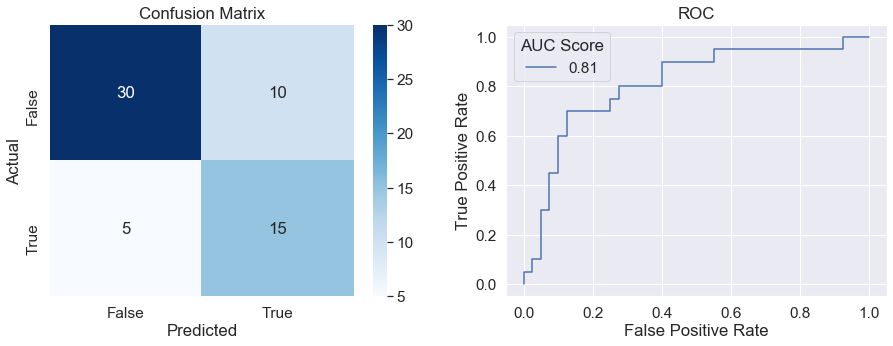

In [53]:
x_train, x_test, y_train, y_test = train_test_sets[2]
clf = classifiers[2]

y_pred = clf.predict(x_test)
y_pred_prob = best_clf.predict_proba(x_test)[:,1]
y_pred = y_pred_prob > 0.3


print('Best parameters:')
print(clf.get_params)
# print(f"Decision Threshold: {decision_threshold}")
plotConfusionMatrix(y_test, y_pred, y_pred_prob)

In [ ]:
clf = classifiers[2]
x_train, x_test, y_train, y_test = train_test_sets[2]

y_pred_prob = best_clf.predict_proba(x_test)[:,1]
confusion = []

for i in range(101):
    threshold /= 100
    y_pred = y_pred_prob >= threshold
    TP = (y_pred == True) & (y_pred == y_test)
    

In [140]:
features = [classifiers[1].estimators_[i].feature_importances_ for i in range(len(classifiers[1].estimators_))]
prospective_features = set()

for fea in features:
    prospective_features.update(set(full_input_v2.columns[fea>0]))
    
list(prospective_features)

['HGB_deltaAvg',
 'TREATMENT_DUR',
 'SBP_delta',
 'SBP_deltaAvg',
 'HGB_mean',
 'DRUG_AVG_DOSAGE_avg',
 'HGB_deltaLatest',
 'DBP_delta',
 'ldl_max',
 'SBP_mean',
 'glucose_deltaLatest',
 'creatinine_mean',
 'DRUG_STRENGTH_avg',
 'glucose_max',
 'glucose_delta',
 'HGB_min',
 'ldl_deltaLatest',
 'MEASURE_CNT',
 'DBP_deltaAvg',
 'DRUG_CNT',
 'creatinine_deltaAvg',
 'ldl_mean',
 'DRUG_STRENGTH_max',
 'DBP_deltaLatest',
 'ldl_delta',
 'DOSAGE_TOTAL',
 'ldl_deltaAvg',
 'DRUG_POPULARITY_avg',
 'SBP_deltaLatest',
 'glucose_mean',
 'glucose_min',
 'glucose_deltaAvg',
 'AGE',
 'SBP_max',
 'creatinine_min',
 'AVG_TREATMENT_DUR',
 'HGB_delta',
 'DBP_max']

In [147]:
x_train, x_test, y_train, y_test = train_test_sets[2]

for i in range(len(classifiers[1].estimators_)):
    try:
        viz = dtreeviz(classifiers[1].estimators_[i],
                       x_test, y_test,
                      feature_names=x_test.columns,
                      class_names = [True, False],
                      title=f"CDK Data - Decision Tree - {i}")
        viz.save(f'DecisionTree -data3- {i}.svg')
    except:
        continue

Best parameters:
{'C': 1, 'penalty': 'l1', 'random_state': 42, 'tol': 0.001}
              precision    recall  f1-score   support

       False       0.76      0.88      0.81        40
        True       0.64      0.45      0.53        20

   micro avg       0.73      0.73      0.73        60
   macro avg       0.70      0.66      0.67        60
weighted avg       0.72      0.73      0.72        60

Best parameters:
{'C': 1, 'penalty': 'l1', 'random_state': 42, 'tol': 0.0001}
              precision    recall  f1-score   support

       False       0.76      0.88      0.81        40
        True       0.64      0.45      0.53        20

   micro avg       0.73      0.73      0.73        60
   macro avg       0.70      0.66      0.67        60
weighted avg       0.72      0.73      0.72        60

Best parameters:
{'C': 1, 'penalty': 'l1', 'random_state': 42, 'tol': 0.001}
              precision    recall  f1-score   support

       False       0.78      0.90      0.84        40
     

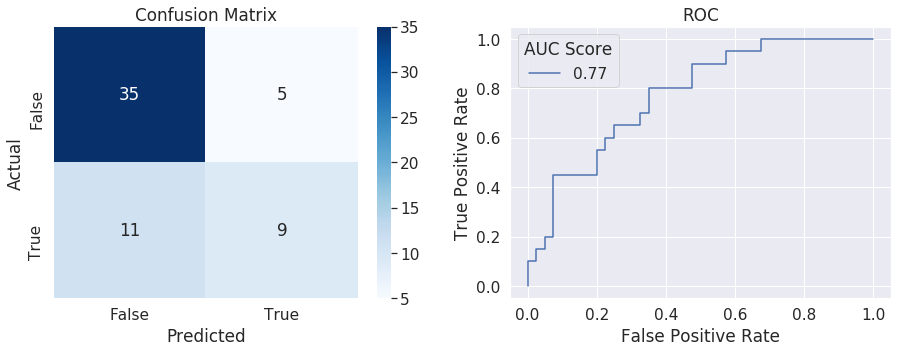

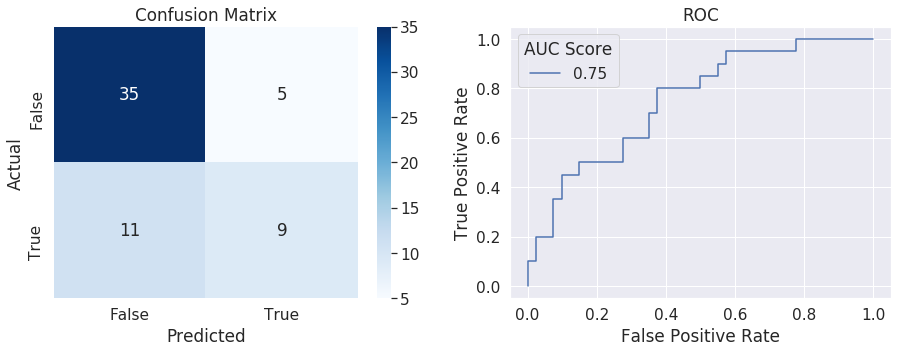

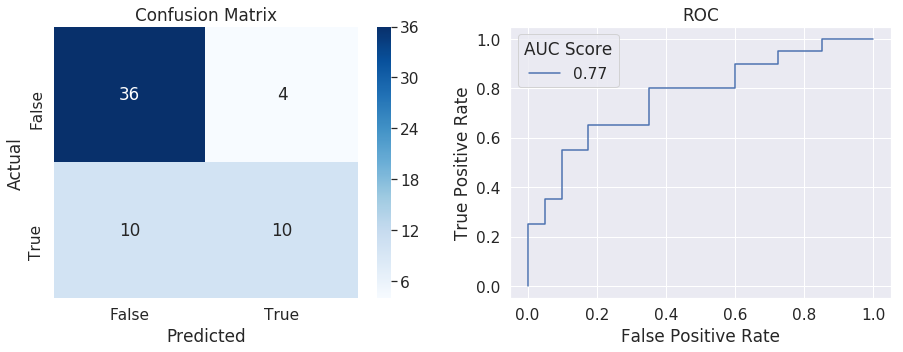

In [104]:
for x_train, x_test, y_train, y_test in train_test_sets:
    
    tuned_parameters = [{'penalty':['l1', 'l2'],
                         'tol':[1e-3, 1e-4, 1e-5, 1e-6],
                         #'class_weight':[None,{0: 0.33,1:0.67}, 'balanced'],
                         'C':[1, 1e-1, 1e-2, 1e-3, 1e-4],
                         # 'solver':['lbfgs', 'liblinear'],
                         'random_state':[42]}]
    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=10,scoring='roc_auc')
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    
    print('Best parameters:')
    print(clf.best_params_)
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)

The pleasant surprise is that the delta value of the measurements are quite strong as they have high coefficients in logistic regression models.  

              precision    recall  f1-score   support

       False       0.66      0.97      0.79        40
        True       0.00      0.00      0.00        20

   micro avg       0.65      0.65      0.65        60
   macro avg       0.33      0.49      0.39        60
weighted avg       0.44      0.65      0.53        60

              precision    recall  f1-score   support

       False       0.67      1.00      0.80        40
        True       0.00      0.00      0.00        20

   micro avg       0.67      0.67      0.67        60
   macro avg       0.33      0.50      0.40        60
weighted avg       0.44      0.67      0.53        60



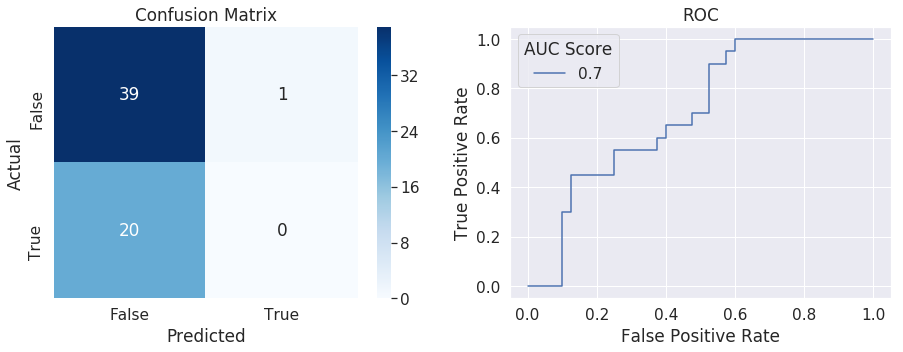

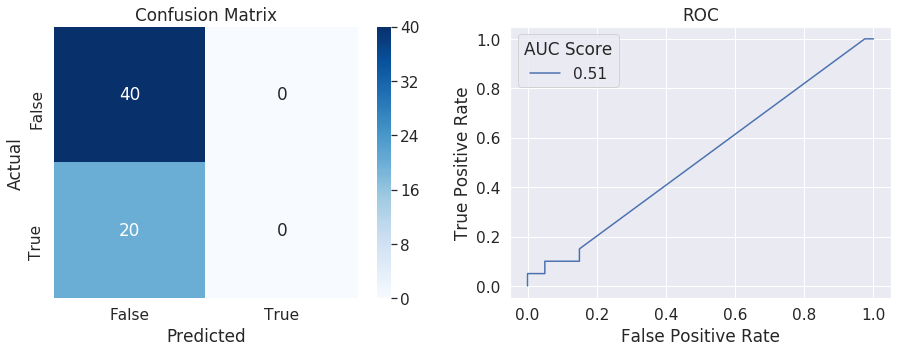

In [52]:
for x_train, x_test, y_train, y_test in train_test_sets:
    
    clf = SVC(probability=True)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)

## PCA  

              precision    recall  f1-score   support

       False       0.65      0.85      0.74        40
        True       0.25      0.10      0.14        20

   micro avg       0.60      0.60      0.60        60
   macro avg       0.45      0.47      0.44        60
weighted avg       0.52      0.60      0.54        60

              precision    recall  f1-score   support

       False       0.67      0.93      0.78        40
        True       0.40      0.10      0.16        20

   micro avg       0.65      0.65      0.65        60
   macro avg       0.54      0.51      0.47        60
weighted avg       0.58      0.65      0.57        60

              precision    recall  f1-score   support

       False       0.67      0.88      0.76        40
        True       0.38      0.15      0.21        20

   micro avg       0.63      0.63      0.63        60
   macro avg       0.52      0.51      0.49        60
weighted avg       0.57      0.63      0.58        60



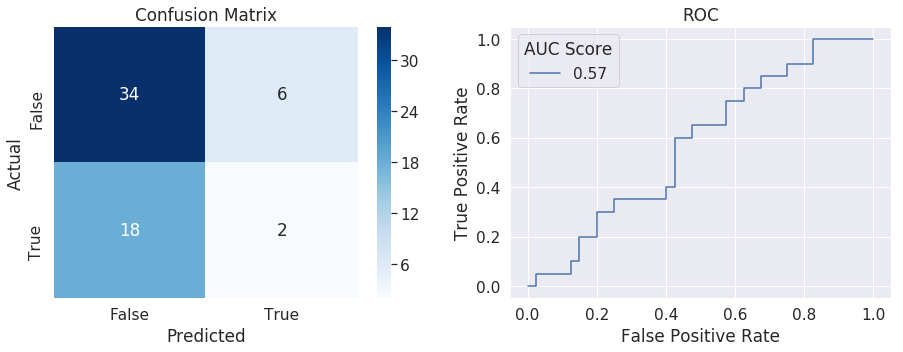

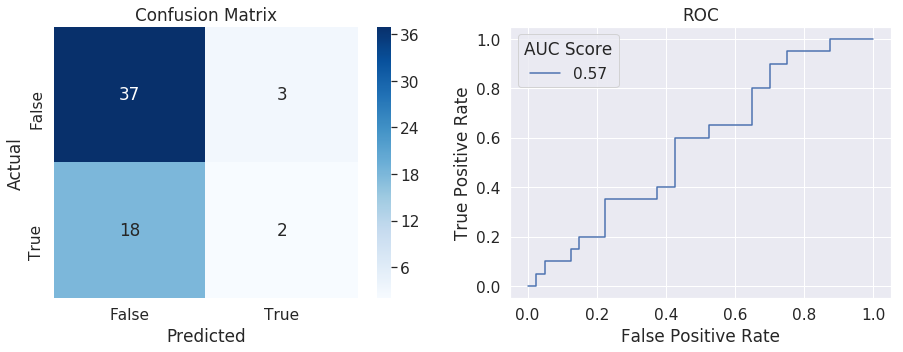

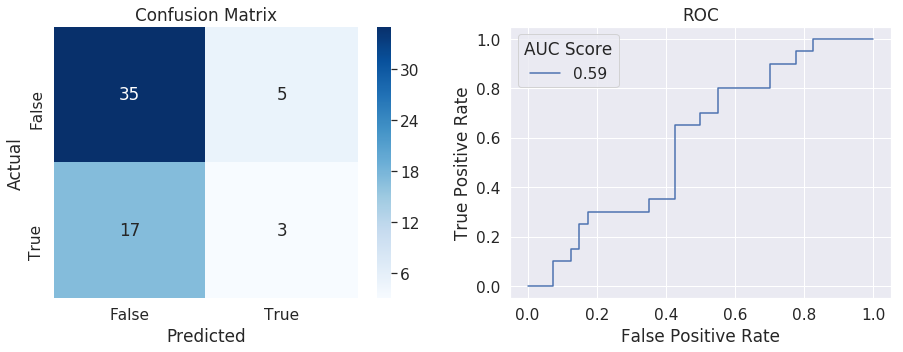

In [117]:

for x_train, x_test, y_train, y_test in train_test_sets_pca3:
    
    clf = LogisticRegression(random_state=0).fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)

The performance does not exactly improve but the AUC has increased.  

## Try more  

              precision    recall  f1-score   support

       False       0.66      0.93      0.77        40
        True       0.25      0.05      0.08        20

   micro avg       0.63      0.63      0.63        60
   macro avg       0.46      0.49      0.43        60
weighted avg       0.52      0.63      0.54        60

              precision    recall  f1-score   support

       False       0.65      0.93      0.76        40
        True       0.00      0.00      0.00        20

   micro avg       0.62      0.62      0.62        60
   macro avg       0.32      0.46      0.38        60
weighted avg       0.43      0.62      0.51        60

              precision    recall  f1-score   support

       False       0.65      0.93      0.76        40
        True       0.00      0.00      0.00        20

   micro avg       0.62      0.62      0.62        60
   macro avg       0.32      0.46      0.38        60
weighted avg       0.43      0.62      0.51        60



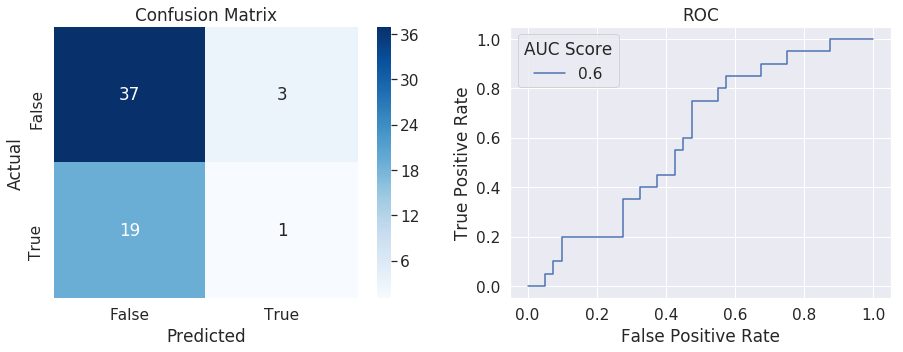

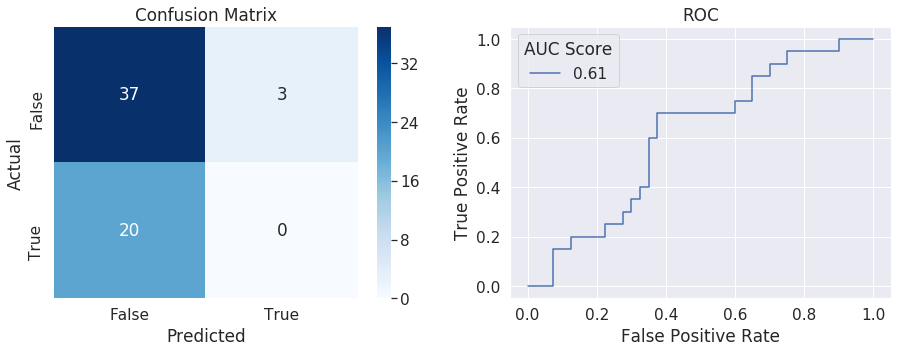

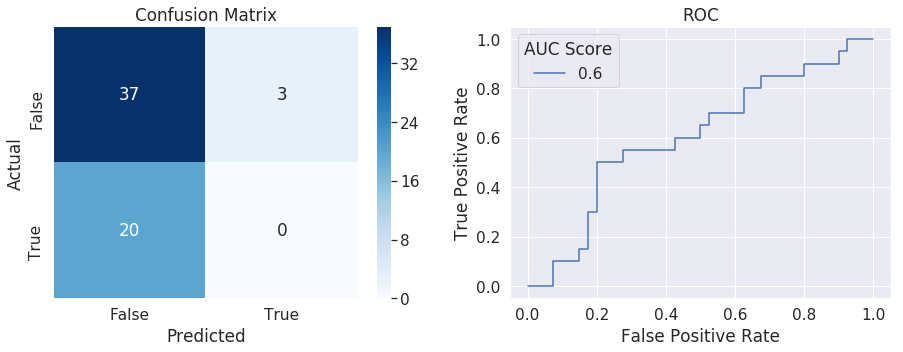

In [118]:
for x_train, x_test, y_train, y_test in train_test_sets_pca3:
    
    SVC_model = SVC(probability=True)

    clf = SVC_model.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)

              precision    recall  f1-score   support

       False       0.64      0.85      0.73        40
        True       0.14      0.05      0.07        20

   micro avg       0.58      0.58      0.58        60
   macro avg       0.39      0.45      0.40        60
weighted avg       0.48      0.58      0.51        60

              precision    recall  f1-score   support

       False       0.66      0.82      0.73        40
        True       0.30      0.15      0.20        20

   micro avg       0.60      0.60      0.60        60
   macro avg       0.48      0.49      0.47        60
weighted avg       0.54      0.60      0.56        60

              precision    recall  f1-score   support

       False       0.67      0.88      0.76        40
        True       0.38      0.15      0.21        20

   micro avg       0.63      0.63      0.63        60
   macro avg       0.52      0.51      0.49        60
weighted avg       0.57      0.63      0.58        60



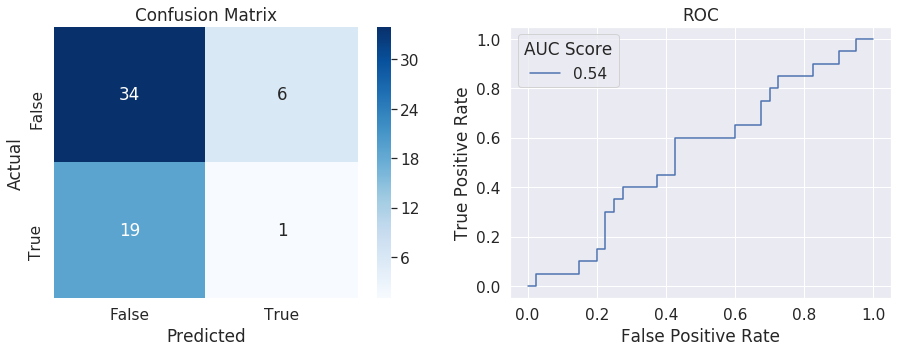

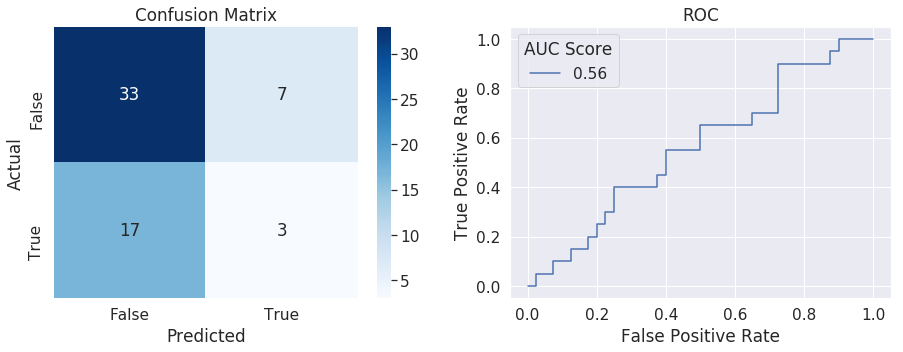

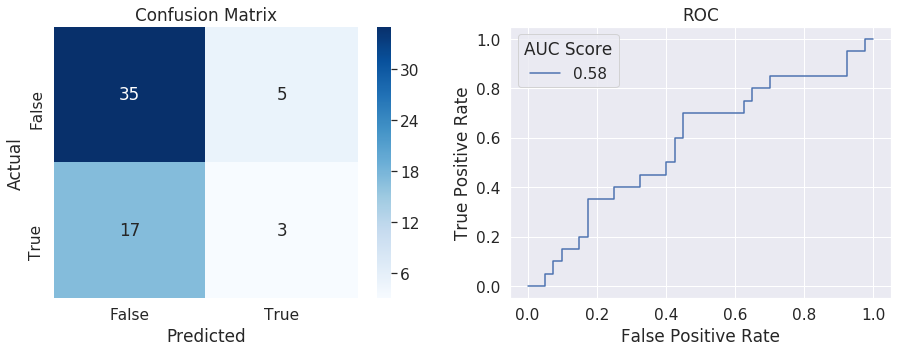

In [119]:
for x_train, x_test, y_train, y_test in train_test_sets_pca3:
    
    model = GaussianNB()

    clf = model.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)

              precision    recall  f1-score   support

       False       0.70      0.65      0.68        40
        True       0.39      0.45      0.42        20

   micro avg       0.58      0.58      0.58        60
   macro avg       0.55      0.55      0.55        60
weighted avg       0.60      0.58      0.59        60

              precision    recall  f1-score   support

       False       0.66      0.68      0.67        40
        True       0.32      0.30      0.31        20

   micro avg       0.55      0.55      0.55        60
   macro avg       0.49      0.49      0.49        60
weighted avg       0.54      0.55      0.55        60

              precision    recall  f1-score   support

       False       0.70      0.75      0.72        40
        True       0.41      0.35      0.38        20

   micro avg       0.62      0.62      0.62        60
   macro avg       0.55      0.55      0.55        60
weighted avg       0.60      0.62      0.61        60



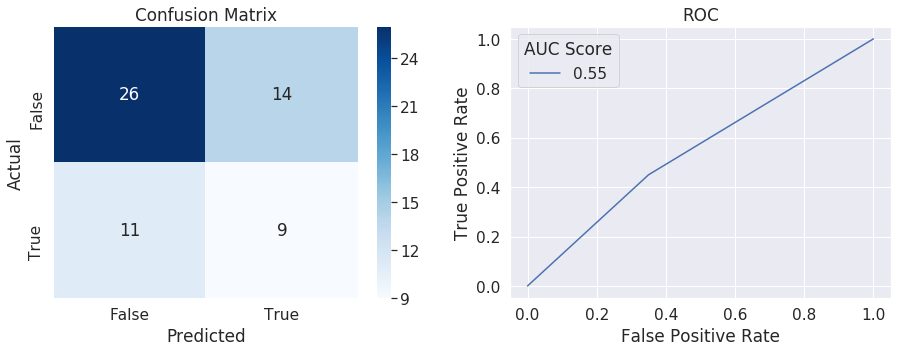

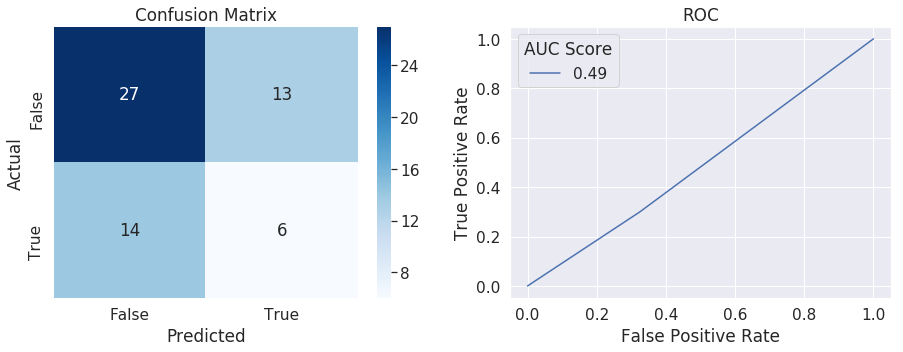

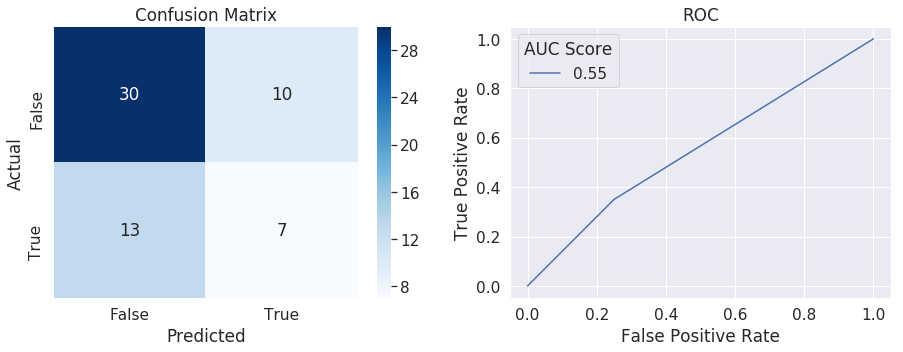

In [120]:
for x_train, x_test, y_train, y_test in train_test_sets_pca3:
    model = DecisionTreeClassifier()

    clf = model.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)

              precision    recall  f1-score   support

       False       0.66      0.88      0.75        40
        True       0.29      0.10      0.15        20

   micro avg       0.62      0.62      0.62        60
   macro avg       0.47      0.49      0.45        60
weighted avg       0.54      0.62      0.55        60

              precision    recall  f1-score   support

       False       0.70      0.93      0.80        40
        True       0.57      0.20      0.30        20

   micro avg       0.68      0.68      0.68        60
   macro avg       0.63      0.56      0.55        60
weighted avg       0.66      0.68      0.63        60

              precision    recall  f1-score   support

       False       0.70      0.88      0.78        40
        True       0.50      0.25      0.33        20

   micro avg       0.67      0.67      0.67        60
   macro avg       0.60      0.56      0.56        60
weighted avg       0.63      0.67      0.63        60



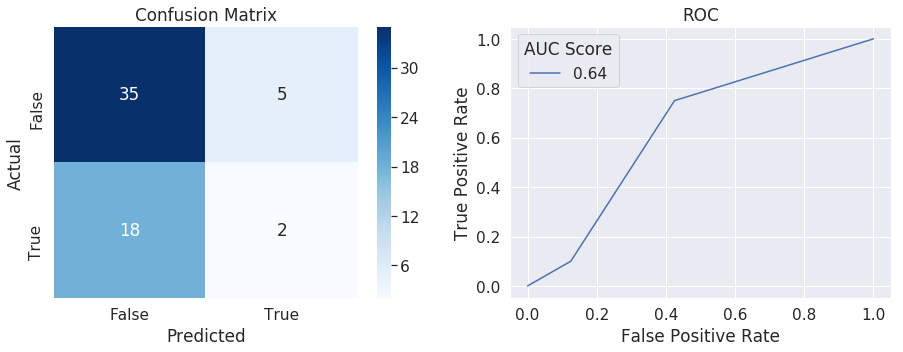

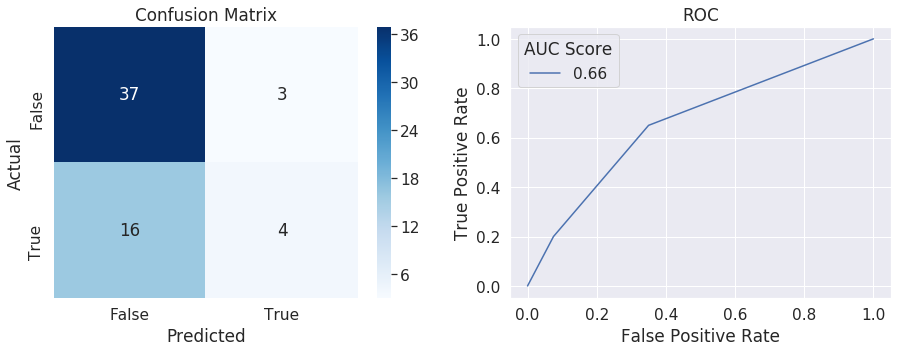

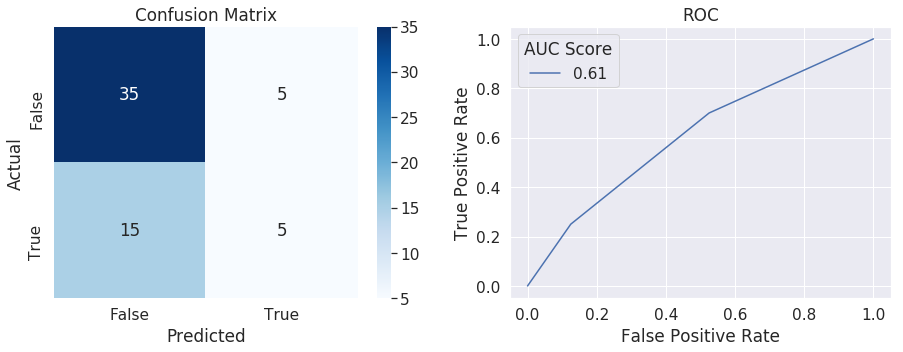

In [123]:

for x_train, x_test, y_train, y_test in train_test_sets_pca3:
    model = KNeighborsClassifier(n_neighbors=2)

    clf = model.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)

Best parameters:
{'max_depth': 4, 'n_estimators': 10, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.67      0.88      0.76        40
        True       0.38      0.15      0.21        20

   micro avg       0.63      0.63      0.63        60
   macro avg       0.52      0.51      0.49        60
weighted avg       0.57      0.63      0.58        60

Best parameters:
{'max_depth': 3, 'n_estimators': 16, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.70      0.97      0.81        40
        True       0.75      0.15      0.25        20

   micro avg       0.70      0.70      0.70        60
   macro avg       0.72      0.56      0.53        60
weighted avg       0.71      0.70      0.62        60

Best parameters:
{'max_depth': 2, 'n_estimators': 9, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.66      0.93      0.77        40
        True    

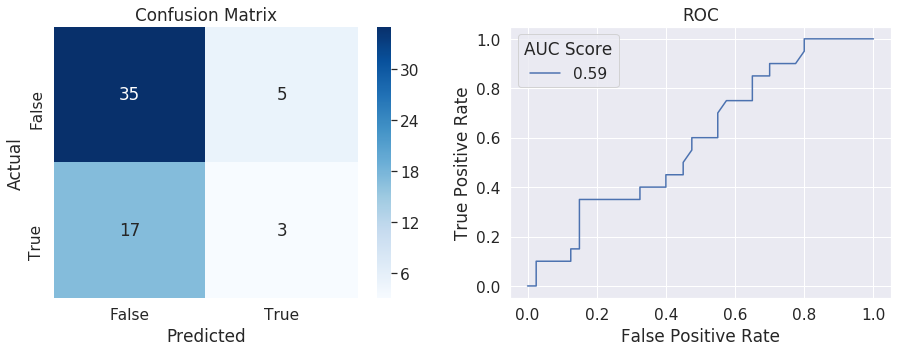

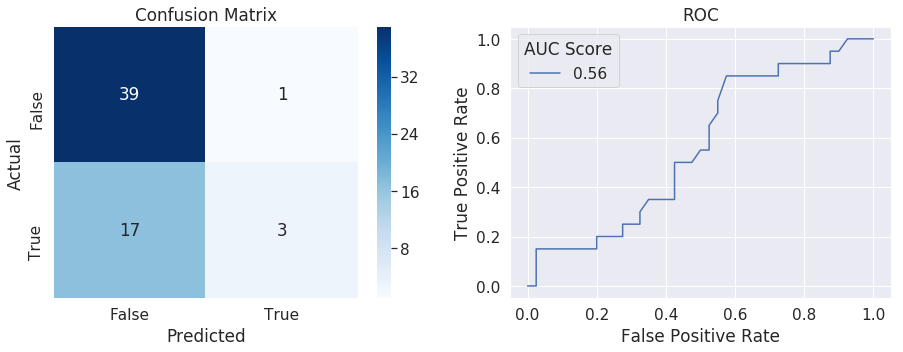

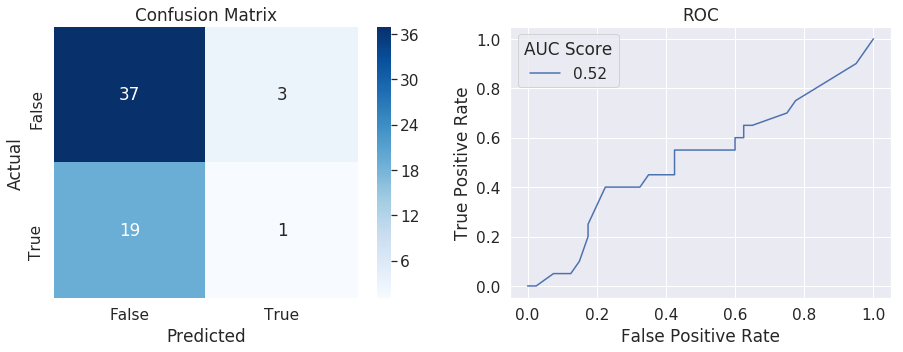

In [166]:
for x_train, x_test, y_train, y_test in train_test_sets_pca3:
    
    tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16],
                         'max_depth':[2,3,4,5,6,None],
                         #'class_weight':[None,{0: 0.33,1:0.67}, 'balanced'],
                         'random_state':[42]}]
    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='roc_auc')
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    
    print('Best parameters:')
    print(clf.best_params_)
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)


Best parameters:
{'max_depth': 4, 'n_estimators': 13, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.70      0.93      0.80        40
        True       0.57      0.20      0.30        20

   micro avg       0.68      0.68      0.68        60
   macro avg       0.63      0.56      0.55        60
weighted avg       0.66      0.68      0.63        60

Best parameters:
{'max_depth': 4, 'n_estimators': 8, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.65      0.90      0.76        40
        True       0.20      0.05      0.08        20

   micro avg       0.62      0.62      0.62        60
   macro avg       0.43      0.48      0.42        60
weighted avg       0.50      0.62      0.53        60

Best parameters:
{'max_depth': 9, 'n_estimators': 9, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.63      0.72      0.67        40
        True     

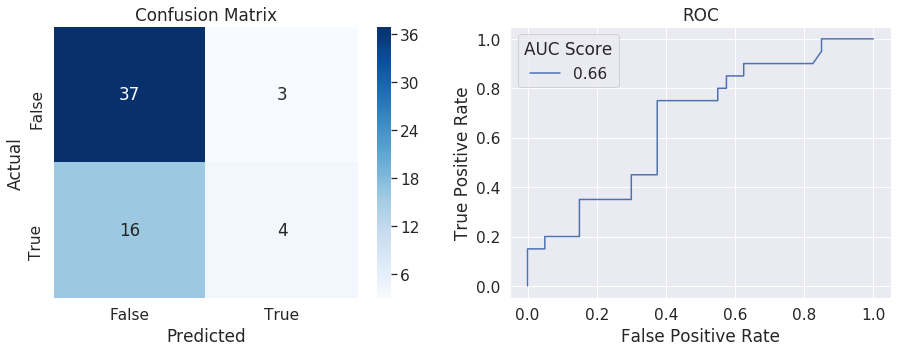

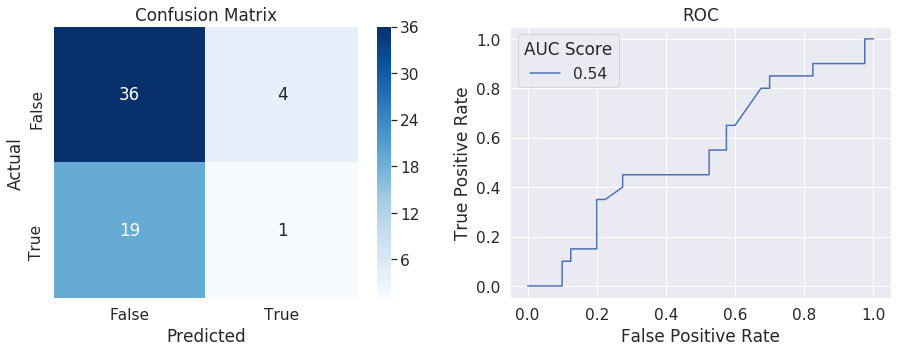

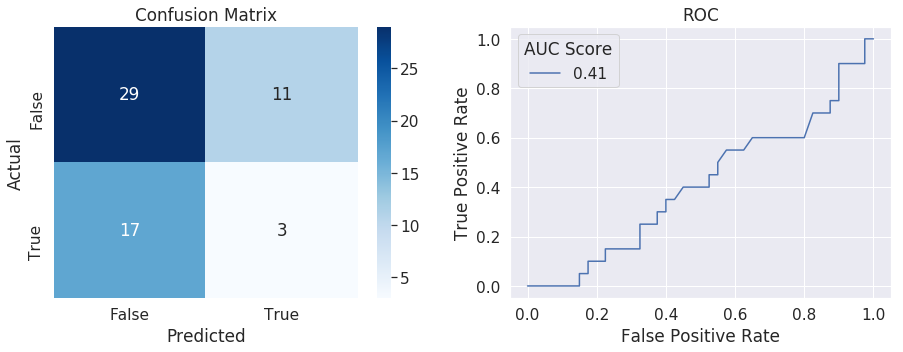

In [157]:
classifiers = []
for x_train, x_test, y_train, y_test in train_test_sets_pca3:
    
    tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16, 17, 18, 19, 20],
                         'max_depth':[2,3,4,5,6,7, 8, 9, 10, 11, None],
                         #'class_weight':[None,{0: 0.33,1:0.67}, 'balanced'],
                         'random_state':[42]}]
    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='roc_auc')
    clf.fit(x_train, y_train)
    
    best_clf = clf.best_estimator_

    y_pred = best_clf.predict(x_test)
    y_pred_prob = best_clf.predict_proba(x_test)[:,1]
    
    '''
    accuracy = 0
    decision_threshold = 0
    for threshold in range(0,100):
        threshold /= 100
        y_pred = y_pred_prob >= decision_threshold
        result = y_pred == y_test
    
        this_acc = sum(result)/len(result)
        print(this_acc)
        if this_acc >= accuracy:
            decision_threshold = threshold
            
    y_pred = y_pred_prob >= decision_threshold 
    '''
    
    classifiers.append(best_clf)
    print('Best parameters:')
    print(clf.best_params_)
    # print(f"Decision Threshold: {decision_threshold}")
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)

Best parameters:
{'max_depth': 5, 'n_estimators': 8, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.78      0.95      0.85        40
        True       0.82      0.45      0.58        20

   micro avg       0.78      0.78      0.78        60
   macro avg       0.80      0.70      0.72        60
weighted avg       0.79      0.78      0.76        60

Best parameters:
{'max_depth': 5, 'n_estimators': 17, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.76      0.93      0.83        40
        True       0.73      0.40      0.52        20

   micro avg       0.75      0.75      0.75        60
   macro avg       0.74      0.66      0.67        60
weighted avg       0.75      0.75      0.73        60

Best parameters:
{'max_depth': 6, 'n_estimators': 11, 'random_state': 42}
              precision    recall  f1-score   support

       False       0.80      0.88      0.83        40
        True    

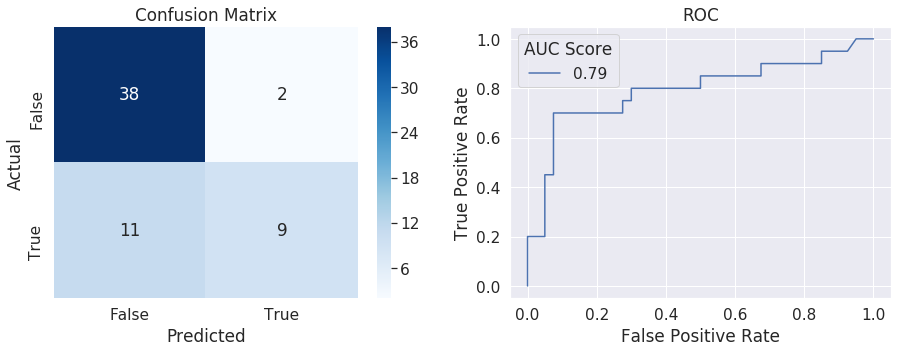

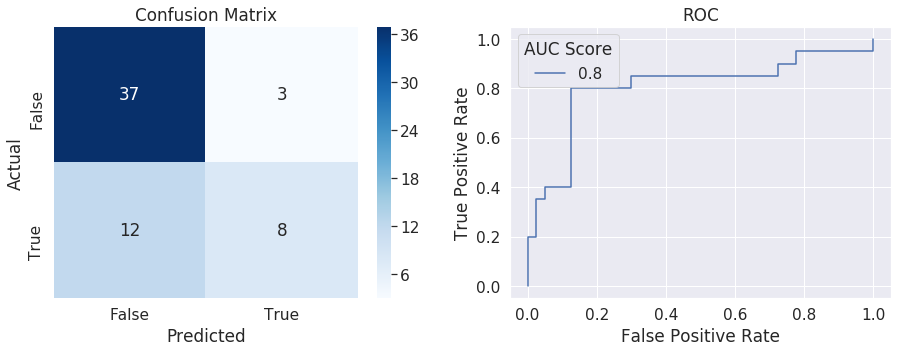

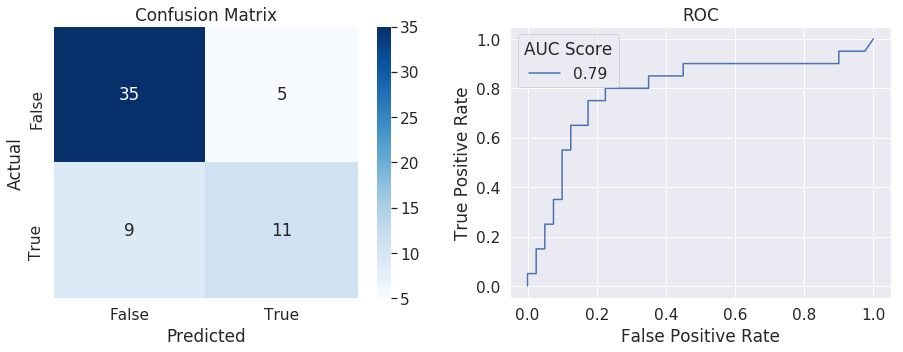

In [161]:
classifiers = []
for x_train, x_test, y_train, y_test in train_test_sets:
    
    tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16, 17, 18, 19, 20],
                         'max_depth':[2,3,4,5,6,7, 8, 9, 10, 11, None],
                         #'class_weight':[None,{0: 0.33,1:0.67}, 'balanced'],
                         'random_state':[42]}]
    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='f1')
    clf.fit(x_train, y_train)
    
    best_clf = clf.best_estimator_

    y_pred = best_clf.predict(x_test)
    y_pred_prob = best_clf.predict_proba(x_test)[:,1]
    
    '''
    accuracy = 0
    decision_threshold = 0
    for threshold in range(0,100):
        threshold /= 100
        y_pred = y_pred_prob >= decision_threshold
        result = y_pred == y_test
    
        this_acc = sum(result)/len(result)
        print(this_acc)
        if this_acc >= accuracy:
            decision_threshold = threshold
            
    y_pred = y_pred_prob >= decision_threshold 
    '''
    
    classifiers.append(best_clf)
    print('Best parameters:')
    print(clf.best_params_)
    # print(f"Decision Threshold: {decision_threshold}")
    plotConfusionMatrix(y_test, y_pred, y_pred_prob)